In [ ]:
# Analisi della relazione tra n_bld e i diversi Speech Rate considerando la struttura gerarchica dei dati
# Caricamento dei dati
data <- read.csv("df_disfl.csv")


#install.packages("dplyr")
#install.packages("lme4")
#install.packages("glmmTMB")
#install.packages("ggplot2")
#install.packages("sjPlot")
#install.packages("DHARMa")
#install.packages("car")
#install.packages("xtable")

suppressPackageStartupMessages({
  library(dplyr)
  library(lme4)     # Per modelli lineari a effetti misti
  library(glmmTMB)  # Per modelli generalizzati a effetti misti
  library(ggplot2)  # Per visualizzazioni
  library(sjPlot)   # Per visualizzare risultati dei modelli
  library(DHARMa)   # Per diagnostica di modelli generalizzati
  library(car)
  library(tidyverse)    # Per test di multicollinearità
  library(xtable)
})



# Defining Function for dharma
run_dharma_diagnostics <- function(model, title = "DHARMa residual diagnostics") {
  # Simulazione dei residui
  sim_residuals <- simulateResiduals(model)

  # Plot standard dei residui DHARMa con tutti i test integrati
  par(mfrow = c(1, 2))
  plot(sim_residuals, main = title)

  # Eseguiamo test aggiuntivi con output grafico
  par(mfrow = c(2, 2))
  testDispersion(sim_residuals)
  testZeroInflation(sim_residuals)
  testOutliers(sim_residuals)
  testUniformity(sim_residuals)

  # Ritorniamo l'oggetto simulazione per uso futuro
  return(sim_residuals)
}


#Defining function for dharma plots
plot_dharma_residuals_ggplot <- function(sim_residuals) {
  resid_df <- data.frame(
    predicted = sim_residuals$fittedPredictedResponse,
    residual = sim_residuals$scaledResiduals
  )

  # Grafico dei residui vs valori predetti
  p1 <- ggplot(resid_df, aes(x = predicted, y = residual)) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "loess", color = "red", se = TRUE) +
    geom_hline(yintercept = 0.5, linetype = "dashed") +
    labs(
      title = "DHARMa Residuals vs. Predicted",
      x = "Predicted values (rank transformed)",
      y = "DHARMa residuals"
    ) +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", hjust = 0.5))

  # QQ-plot
  p2 <- ggplot(resid_df, aes(sample = residual)) +
    stat_qq(distribution = qunif) +
    stat_qq_line(distribution = qunif, color = "red") +
    labs(
      title = "DHARMa QQ Plot",
      x = "Expected",
      y = "Observed"
    ) +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", hjust = 0.5))

  p3 <- ggplot(resid_df, aes(x = residual)) +
    geom_histogram(bins = 30, fill = "steelblue", color = "black", alpha = 0.7) +
    geom_vline(xintercept = 0.5, linetype = "dashed", color = "red") +
    labs(
      title = "Histogram of DHARMa residuals",
      x = "DHARMa residuals",
      y = "Frequency"
    ) +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", hjust = 0.5))

  list(p1 = p1, p2 = p2, p3 = p3)
}





###defining functions for plots###

create_prediction_grid <- function(model, data) {
  sr_range <- range(data$SR_phon_phono_Norm, na.rm = TRUE)
  range_extension <- 0.1 * (sr_range[2] - sr_range[1])
  sr_min <- max(-2, sr_range[1] - range_extension) # Non andare sotto -2
  sr_max <- sr_range[2] + range_extension

  sr_seq <- seq(sr_min, sr_max, length.out = 100)


  speakers <- levels(data$Speaker)

  pred_grid <- expand.grid(
    SR_phon_phono_Norm = sr_seq,
    Speaker = speakers
  )

  return(pred_grid)
}


plot_zi_model_predictions <- function(model, data) {
  # Identifichiamo la variabile SR
  sr_var <- "SR_phon_phono_Norm"

  # Creiamo un range semplice per SR
  sr_range <- range(data[[sr_var]], na.rm = TRUE)
  sr_seq <- seq(from = sr_range[1], to = sr_range[2], length.out = 50)

  # Recuperiamo gli speakers
  speakers <- sort(unique(as.character(data$Speaker)))

  # Creiamo il dataframe manualmente per ogni speaker
  all_preds <- data.frame()

  for (spk in speakers) {
    # Creiamo un nuovo dataframe temporaneo per questo speaker
    temp_df <- data.frame(SR_phon_phono_Norm = sr_seq)
    temp_df$Speaker <- factor(spk, levels = speakers)

    # Facciamo le predizioni
    preds <- tryCatch({
      conditional <- predict(model, newdata = temp_df, type = "response")
      data.frame(
        Speaker = spk,
        SR = sr_seq,
        predicted = conditional
      )
    }, error = function(e) {
      cat("Errore per Speaker", spk, ":", conditionMessage(e), "\n")
      return(NULL)
    })

    if (!is.null(preds)) {
      all_preds <- rbind(all_preds, preds)
    }
  }

  # Se siamo riusciti a fare predizioni
  if (nrow(all_preds) > 0) {
    # Grafico
    plot(all_preds$SR, all_preds$predicted,
         type = "n",
         xlab = "Speech Rate",
         ylab = "Predicted Count",
         main = "Predicted Counts by Speech Rate")

    # Colori per gli speakers
    colors <- rainbow(length(speakers))

    # Plot per ciascun speaker
    for (i in seq_along(speakers)) {
      spk <- speakers[i]
      spk_data <- all_preds[all_preds$Speaker == spk, ]

      if (nrow(spk_data) > 0) {
        lines(spk_data$SR, spk_data$predicted,
              col = colors[i], lwd = 2)
      }
    }

    # Legenda
    legend("topright", legend = speakers,
           col = colors, lty = 1, lwd = 2)
  } else {
    cat("Non è stato possibile generare predizioni.\n")
  }

  return(all_preds)
}

#Functions for Latex


format_number <- function(x) {
  ifelse(abs(x) < 0.001, "$<$ .001", sprintf("%.3f", x))
}


model_summary_latex <- function(model, caption = "Model summary", label = "model1") {
  coef_count <- summary(model)$coefficients$cond

  coef_zi <- summary(model)$coefficients$zi
  count_df <- data.frame(
    Part = rep("Conditional part", nrow(coef_count)),
    Term = rownames(coef_count),
    Estimate = coef_count[, 1],
    Std_Error = coef_count[, 2],
    z_value = coef_count[, 3],
    p_value = coef_count[, 4],
    stringsAsFactors = FALSE
  )

  zi_df <- data.frame(
    Part = rep("Zero-inflated part", nrow(coef_zi)),
    Term = rownames(coef_zi),
    Estimate = coef_zi[, 1],
    Std_Error = coef_zi[, 2],
    z_value = coef_zi[, 3],
    p_value = coef_zi[, 4],
    stringsAsFactors = FALSE
  )

  all_df <- rbind(count_df, zi_df)


  all_df$sig <- ""
  all_df$sig[all_df$p_value < 0.001] <- "***"
  all_df$sig[all_df$p_value >= 0.001 & all_df$p_value < 0.01] <- "**"
  all_df$sig[all_df$p_value >= 0.01 & all_df$p_value < 0.05] <- "*"
  all_df$sig[all_df$p_value >= 0.05 & all_df$p_value < 0.1] <- "."
  all_df$p_value_fmt <- sapply(all_df$p_value, format_number)

  vc <- VarCorr(model)
  var_speaker <- as.numeric(vc$cond$Speaker[1])


  latex_code <- "\\begin{table}[h!]\n\\centering\n\\small\n"
  latex_code <- paste0(latex_code, "\\begin{tabular}{|l r r r r|}\n\\hline\n")

  latex_code <- paste0(latex_code, "Conditional part & & & & \\\\\n\\hline\n")


  latex_code <- paste0(latex_code, " & Estimate & Std.\\ Error & z value & p \\\\ \\hline\n")


  for(i in 1:nrow(count_df)) {

    term_name <- count_df$Term[i]
    if(term_name == "(Intercept)") {
      term_name <- "(Intercept)"
    } else {

      term_name <- gsub("_", "\\_", term_name)
    }

    latex_code <- paste0(latex_code,
                         term_name, " & ",
                         sprintf("%.3f", count_df$Estimate[i]), " & ",
                         sprintf("%.3f", count_df$Std_Error[i]), " & ",
                         sprintf("%.3f", count_df$z_value[i]), " & ",
                         count_df$p_value_fmt[i], " ", count_df$sig[i], " \\\\\n")
  }

  latex_code <- paste0(latex_code, "\\hline\nZero-inflated part & & & & \\\\\n\\hline\n")


  for(i in 1:nrow(zi_df)) {
    term_name <- zi_df$Term[i]
    if(term_name == "(Intercept)") {
      term_name <- "(Intercept)"
    } else {
      term_name <- gsub("_", "\\_", term_name)
    }


    latex_code <- paste0(latex_code,
                         term_name, " & ",
                         sprintf("%.3f", zi_df$Estimate[i]), " & ",
                         sprintf("%.3f", zi_df$Std_Error[i]), " & ",
                         sprintf("%.3f", zi_df$z_value[i]), " & ",
                         zi_df$p_value_fmt[i], " ", zi_df$sig[i], " \\\\\n")
  }


  latex_code <- paste0(latex_code, "\\hline\n\\end{tabular}\n")


  caption_with_random <- paste0(caption, " (with random effect for Speaker, Var = ",
                               sprintf("%.3f", var_speaker), ")")

  latex_code <- paste0(latex_code,
                       "\\caption{", caption_with_random, "} \\label{", label, "}\n")


  latex_code <- paste0(latex_code, "\\end{table}\n\\noindent\n")


  return(latex_code)
}






ERROR: Error in library(lme4): there is no package called ‘lme4’


 Family: poisson  ( log )
Formula:          DSTR_count ~ SR_phon_phono_Norm + (1 | Speaker)
Zero inflation:              ~SR_phon_phono_Norm
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
   2007.4    2029.5    -998.7    1997.4       609 

Random effects:

Conditional model:
 Groups  Name        Variance Std.Dev.
 Speaker (Intercept) 0.02473  0.1572  
Number of obs: 614, groups:  Speaker, 4

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.50404    0.09166   5.499 3.82e-08 ***
SR_phon_phono_Norm -0.17256    0.05030  -3.431 0.000602 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.1222     0.3455  -6.143 8.12e-10 ***
SR_phon_phono_Norm  -0.4964     0.2991  -1.660    0.097 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

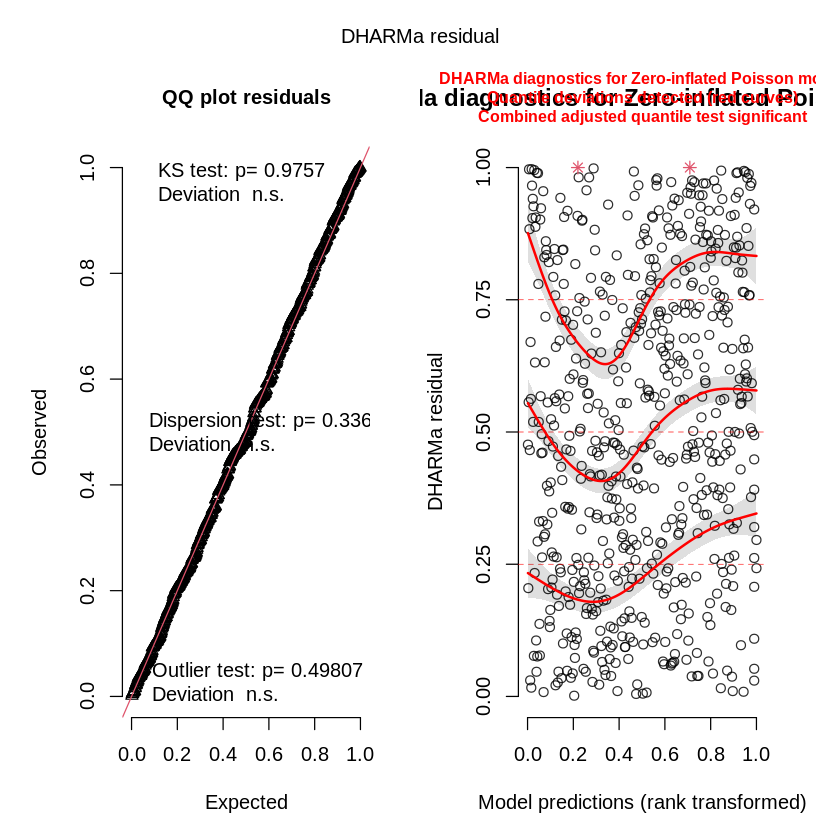

`geom_smooth()` using formula = 'y ~ x'


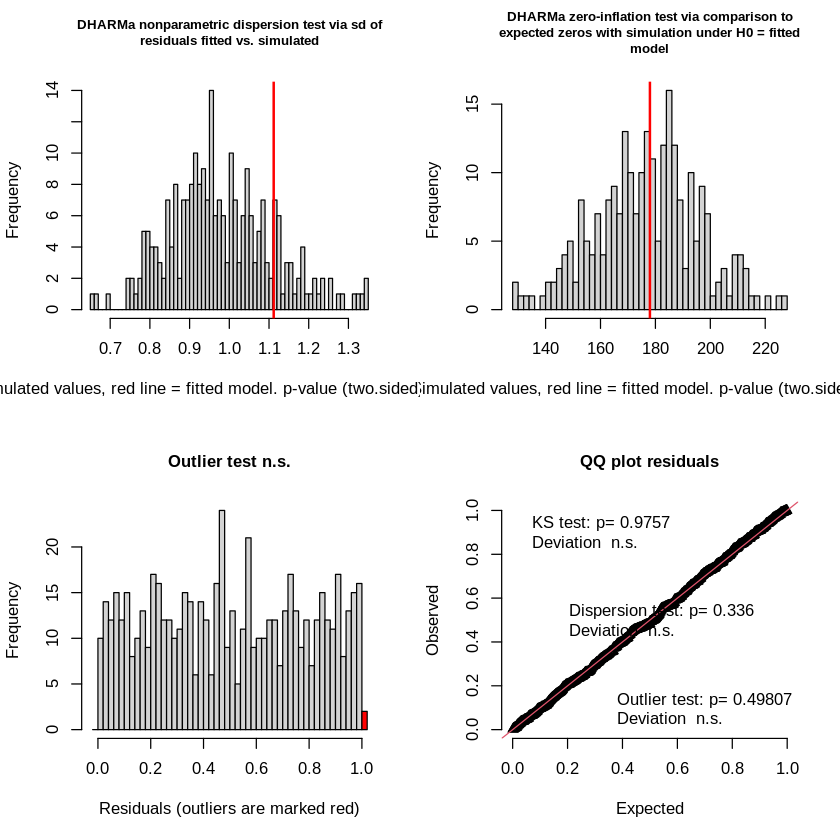

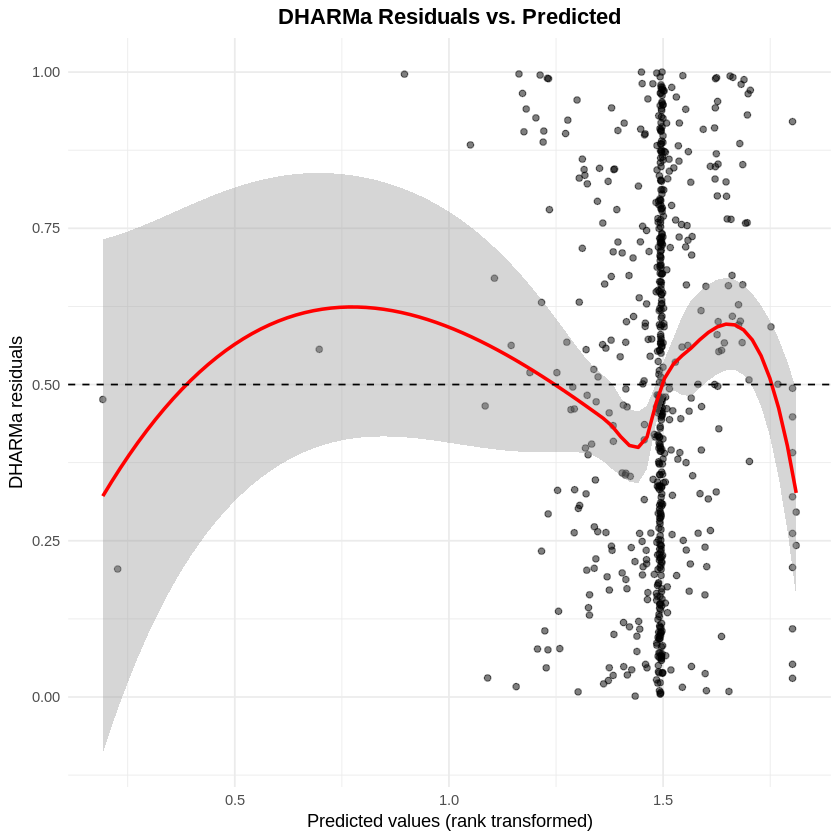

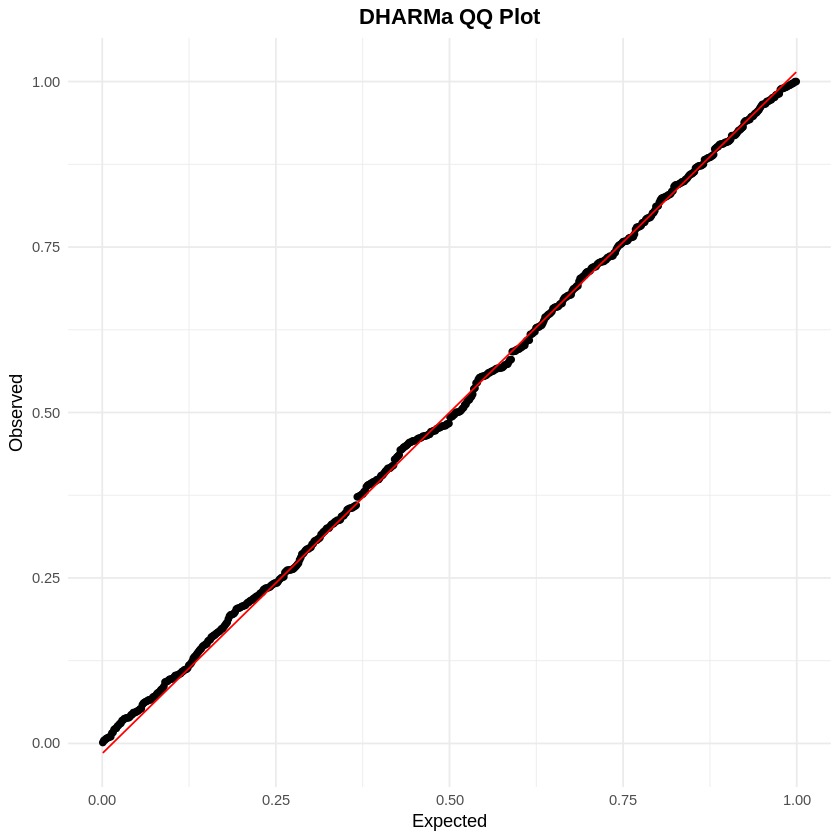

`geom_smooth()` using formula = 'y ~ x'


NULL
NULL
NULL
LaTeX code for model summary:

\begin{table}[h!]
\centering
\small
\begin{tabular}{|l r r r r|}
\hline
Conditional part & & & & \\
\hline
 & Estimate & Std.\ Error & z value & p \\ \hline
(Intercept) & 0.504 & 0.092 & 5.499 &   \\
SR_phon_phono_Norm & -0.173 & 0.050 & -3.431 &   \\
\hline
Zero-inflated part & & & & \\
\hline
(Intercept) & -2.122 & 0.345 & -6.143 &   \\
SR_phon_phono_Norm & -0.496 & 0.299 & -1.660 &   \\
\hline
\end{tabular}
\caption{Model capturing the relationship between number of disfluencies and normalised speech rate (with random effect for Speaker, Var = 0.025)} \label{model1}
\end{table}
\noindent


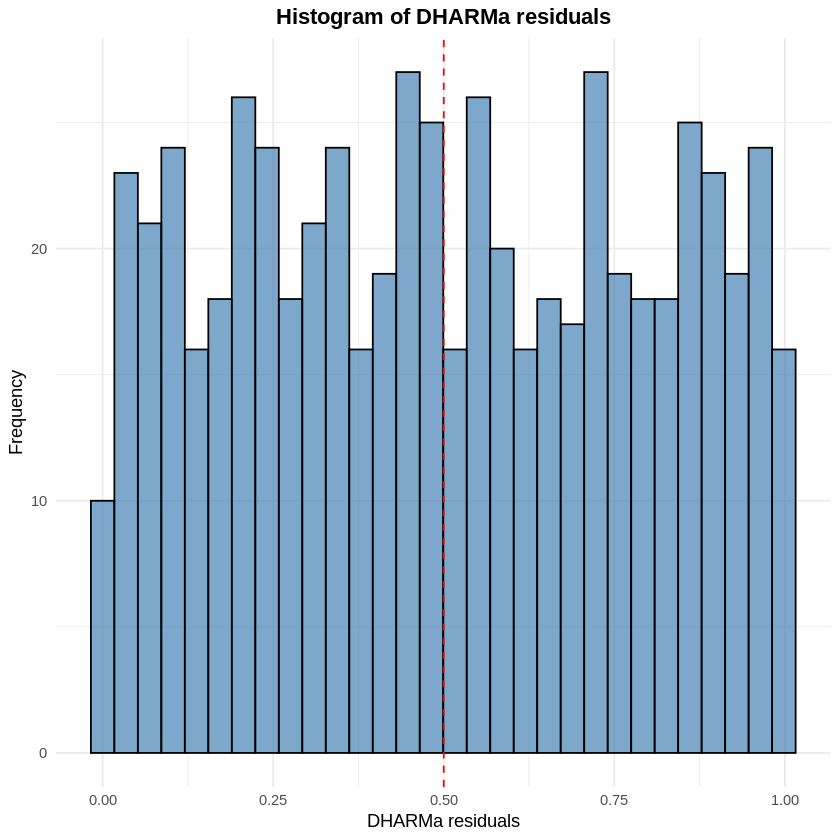

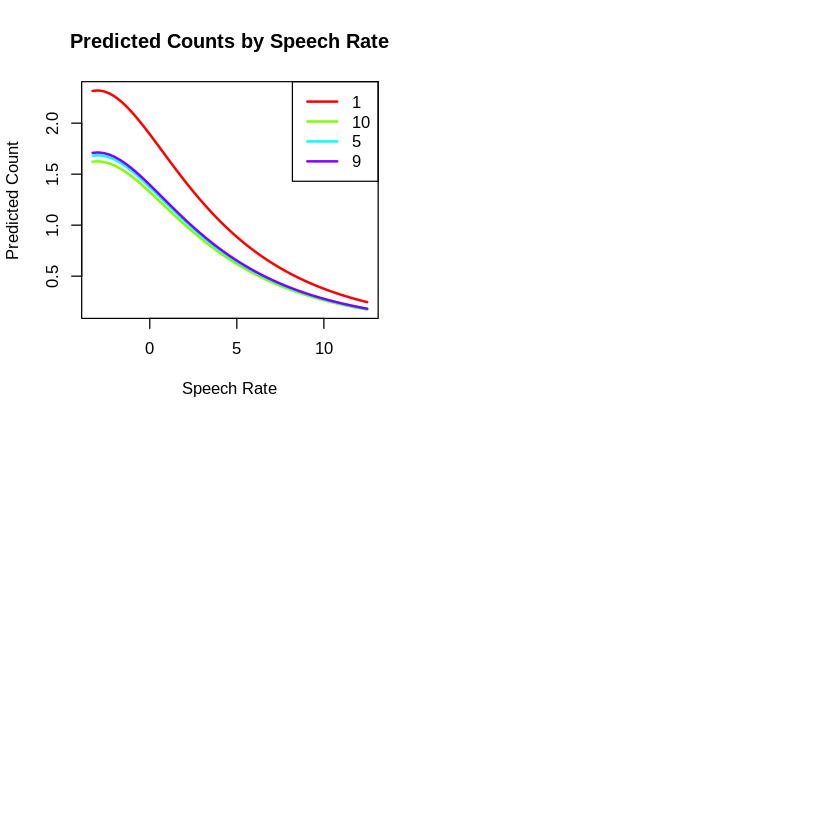

In [ ]:
########################################################################
#################DSTR_COUNT#############################################
########################################################################




zi_model <- glmmTMB(DSTR_count ~ SR_phon_phono_Norm + (1 | Speaker),
                 family = poisson,
                   ziformula = ~ SR_phon_phono_Norm,
                  data = data)
summary(zi_model)







######### Esecuzione della diagnostica#############
sim_residuals <- run_dharma_diagnostics(zi_model, "DHARMa diagnostics for Zero-inflated Poisson model")
residual_plots <- plot_dharma_residuals_ggplot(sim_residuals)


print(residual_plots$p1)
print(residual_plots$p2)
print(residual_plots$p3)


ggsave("dharma_residuals_vs_predicted.png", residual_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("dharma_qq_plot.png", residual_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("dharma_histogram.png", residual_plots$p3, width = 8, height = 6, dpi = 300)


####################Esecuzione dei plots##################

prediction_plots <- plot_zi_model_predictions(zi_model, data)

# Visualizzazione dei grafici
print(prediction_plots$p1)
print(prediction_plots$p2)
print(prediction_plots$p3)

# Salvataggio dei grafici
ggsave("zi_model_probability_zero.png", prediction_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("zi_model_expected_count.png", prediction_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("zi_model_vs_observed.png", prediction_plots$p3, width = 10, height = 6, dpi = 300)

###########Formattazione tabella in Latex##############

latex_output <- model_summary_latex(zi_model,
                                   "Model capturing the relationship between number of disfluencies and normalised speech rate",
                                   "model1")


cat("LaTeX code for model summary:\n\n")
cat(latex_output)

write(latex_output, "model_summary_latex.txt")






Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”


 Family: poisson  ( log )
Formula:          n_FLD ~ SR_phon_phono_Norm + (1 | Speaker)
Zero inflation:         ~SR_phon_phono_Norm
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
   1794.0    1816.1    -892.0    1784.0       609 

Random effects:

Conditional model:
 Groups  Name        Variance Std.Dev.
 Speaker (Intercept) 0.0322   0.1795  
Number of obs: 614, groups:  Speaker, 4

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.20198    0.09753   2.071 0.038369 *  
SR_phon_phono_Norm -0.19521    0.05189  -3.762 0.000169 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
                   Estimate Std. Error z value Pr(>|z|)
(Intercept)          -80.33   11785.14  -0.007    0.995
SR_phon_phono_Norm   -32.18    4704.67  -0.007    0.995

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



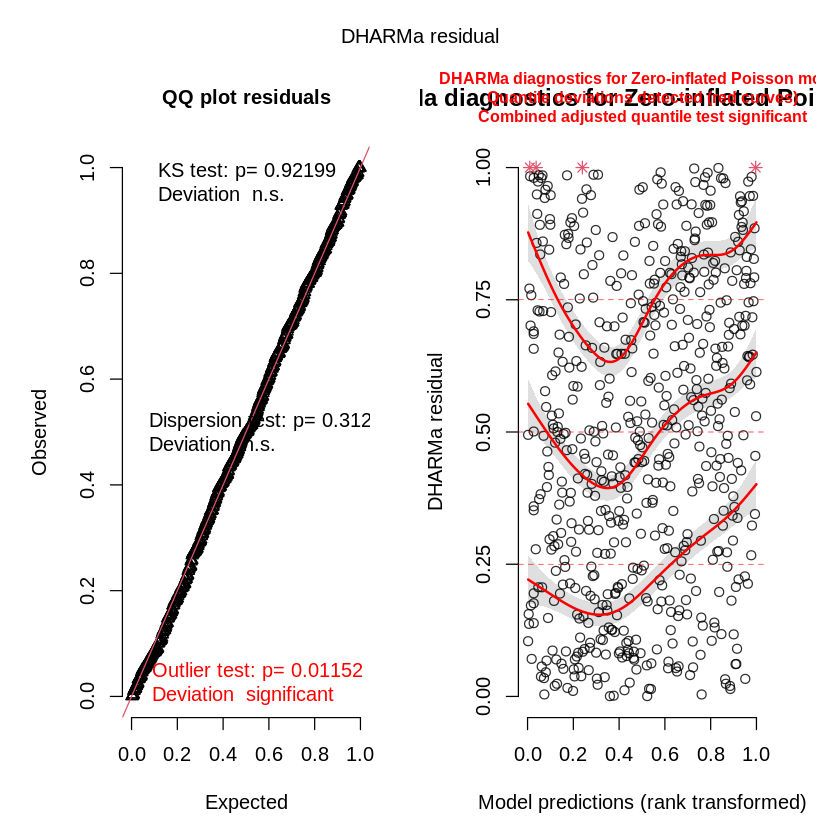

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details

`geom_smooth()` using formula = 'y ~ x'


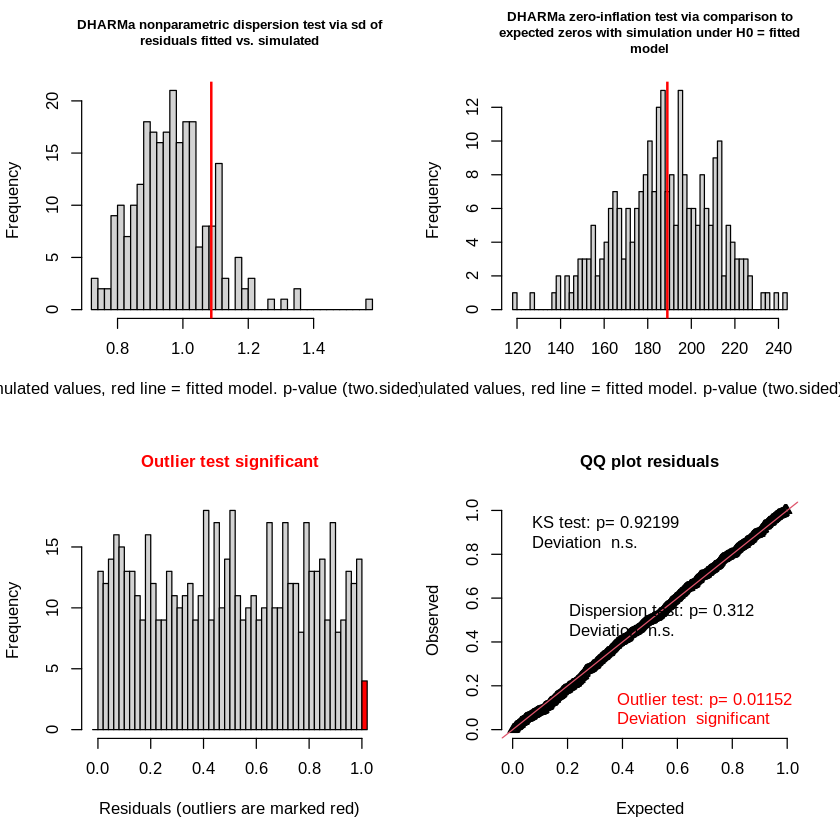

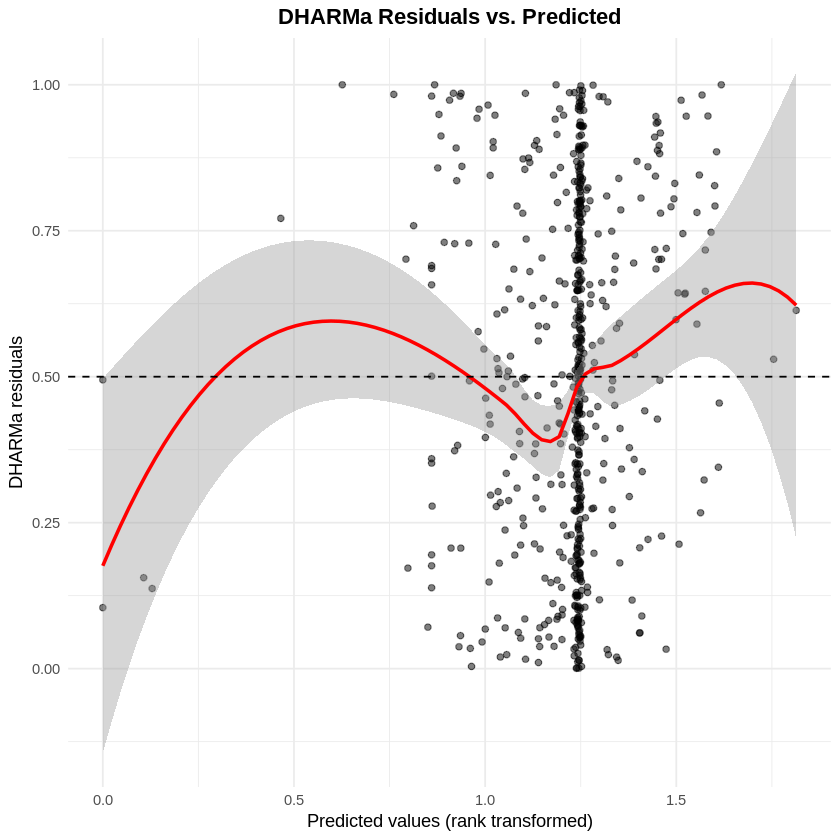

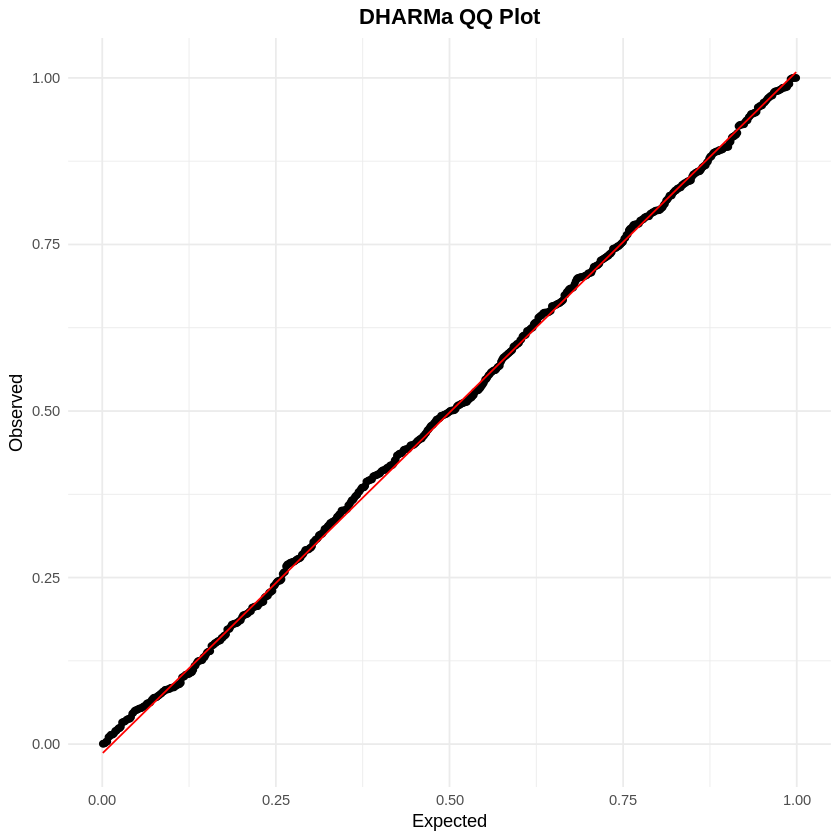

`geom_smooth()` using formula = 'y ~ x'


NULL
NULL
NULL
LaTeX code for model summary:

\begin{table}[h!]
\centering
\small
\begin{tabular}{|l r r r r|}
\hline
Conditional part & & & & \\
\hline
 & Estimate & Std.\ Error & z value & p \\ \hline
(Intercept) & 0.202 & 0.098 & 2.071 &   \\
SR_phon_phono_Norm & -0.195 & 0.052 & -3.762 &   \\
\hline
Zero-inflated part & & & & \\
\hline
(Intercept) & -80.325 & 11785.141 & -0.007 &   \\
SR_phon_phono_Norm & -32.177 & 4704.674 & -0.007 &   \\
\hline
\end{tabular}
\caption{Model capturing the relationship between number of disfluencies and normalised speech rate (with random effect for Speaker, Var = 0.032)} \label{model1}
\end{table}
\noindent


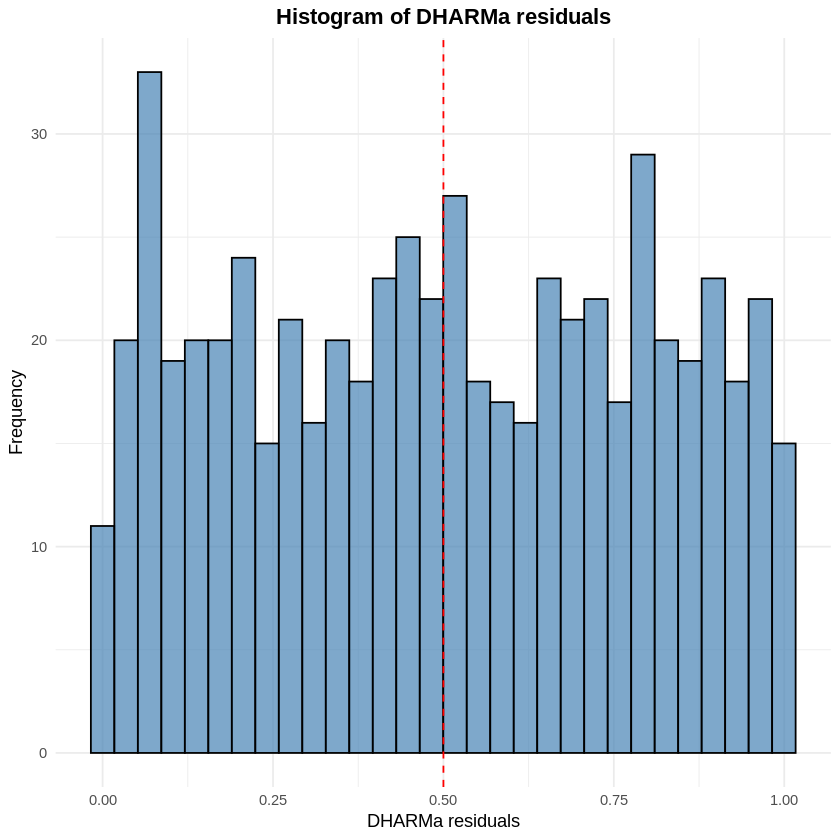

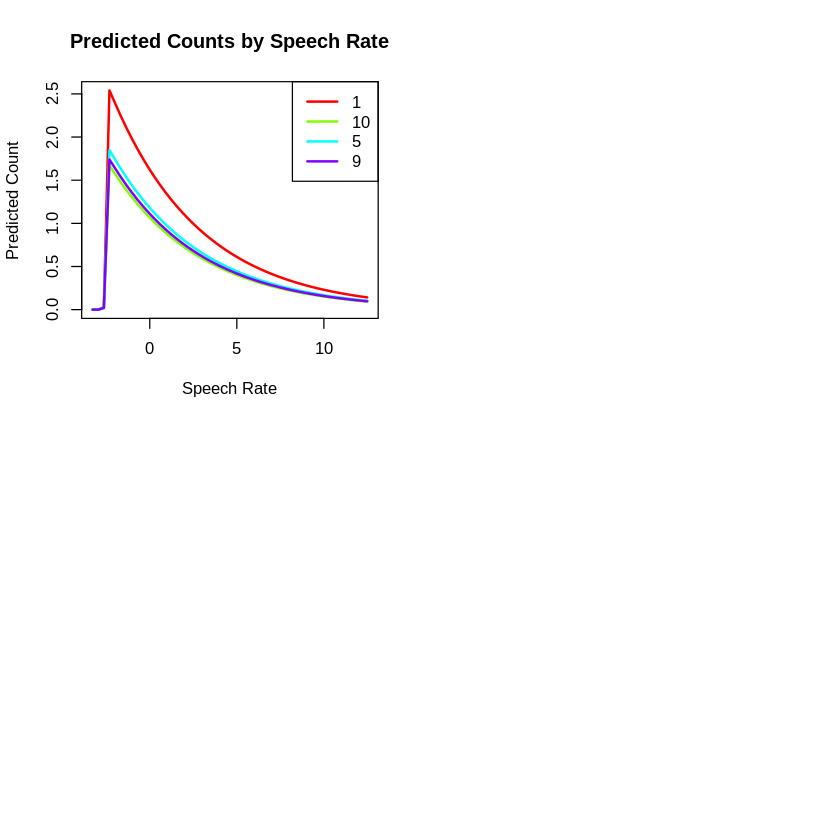

In [ ]:
########################################################################
#################N_FLD#############################################
########################################################################

zi_model <- glmmTMB(n_FLD ~ SR_phon_phono_Norm + (1 | Speaker),
                 family = poisson,
                   ziformula = ~ SR_phon_phono_Norm,
                  data = data)
summary(zi_model)


######### Esecuzione della diagnostica#############
sim_residuals <- run_dharma_diagnostics(zi_model, "DHARMa diagnostics for Zero-inflated Poisson model")
residual_plots <- plot_dharma_residuals_ggplot(sim_residuals)


print(residual_plots$p1)
print(residual_plots$p2)
print(residual_plots$p3)


ggsave("dharma_residuals_vs_predicted.png", residual_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("dharma_qq_plot.png", residual_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("dharma_histogram.png", residual_plots$p3, width = 8, height = 6, dpi = 300)


####################Esecuzione dei plots##################

prediction_plots <- plot_zi_model_predictions(zi_model, data)

# Visualizzazione dei grafici
print(prediction_plots$p1)
print(prediction_plots$p2)
print(prediction_plots$p3)

# Salvataggio dei grafici
ggsave("zi_model_probability_zero.png", prediction_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("zi_model_expected_count.png", prediction_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("zi_model_vs_observed.png", prediction_plots$p3, width = 10, height = 6, dpi = 300)

###########Formattazione tabella in Latex##############

latex_output <- model_summary_latex(zi_model,
                                   "Model capturing the relationship between number of disfluencies and normalised speech rate",
                                   "model1")


cat("LaTeX code for model summary:\n\n")
cat(latex_output)

write(latex_output, "model_summary_latex.txt")

 Family: poisson  ( log )
Formula:          n_bld ~ SR_phon_phono_Norm + (1 | Speaker)
Zero inflation:         ~SR_phon_phono_Norm
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
    565.0     587.1    -277.5     555.0       609 

Random effects:

Conditional model:
 Groups  Name        Variance Std.Dev.
 Speaker (Intercept) 0.2268   0.4762  
Number of obs: 614, groups:  Speaker, 4

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -1.5767     0.3244  -4.861 1.17e-06 ***
SR_phon_phono_Norm   0.2761     0.2462   1.122    0.262    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)         -1.1356     0.7621  -1.490   0.1362   
SR_phon_phono_Norm   2.1991     0.7302   3.012   0.0026 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Warning message in newton(lsp = lsp, X = G$X, y = G$y, Eb = G$Eb, UrS = G$UrS, L = G$L, :
“Fitting terminated with step failure - check results carefully”


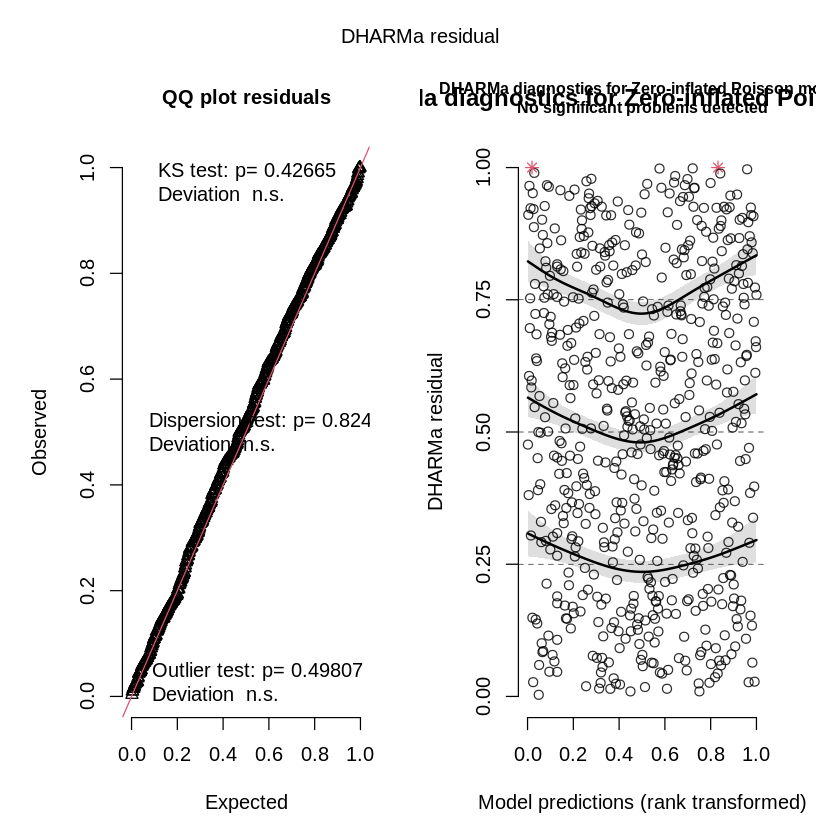

`geom_smooth()` using formula = 'y ~ x'


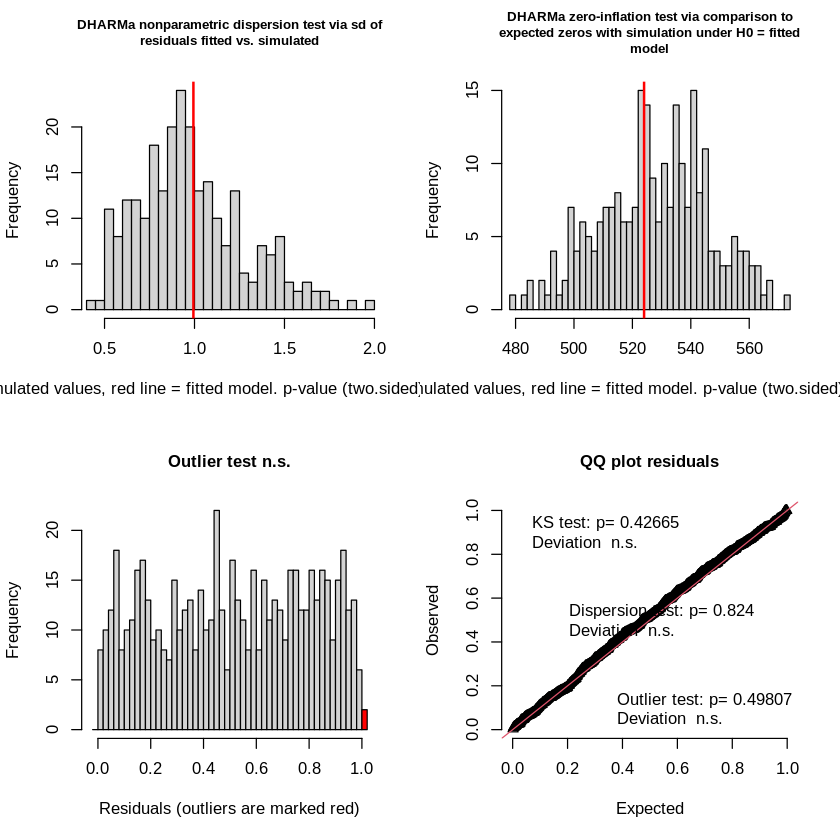

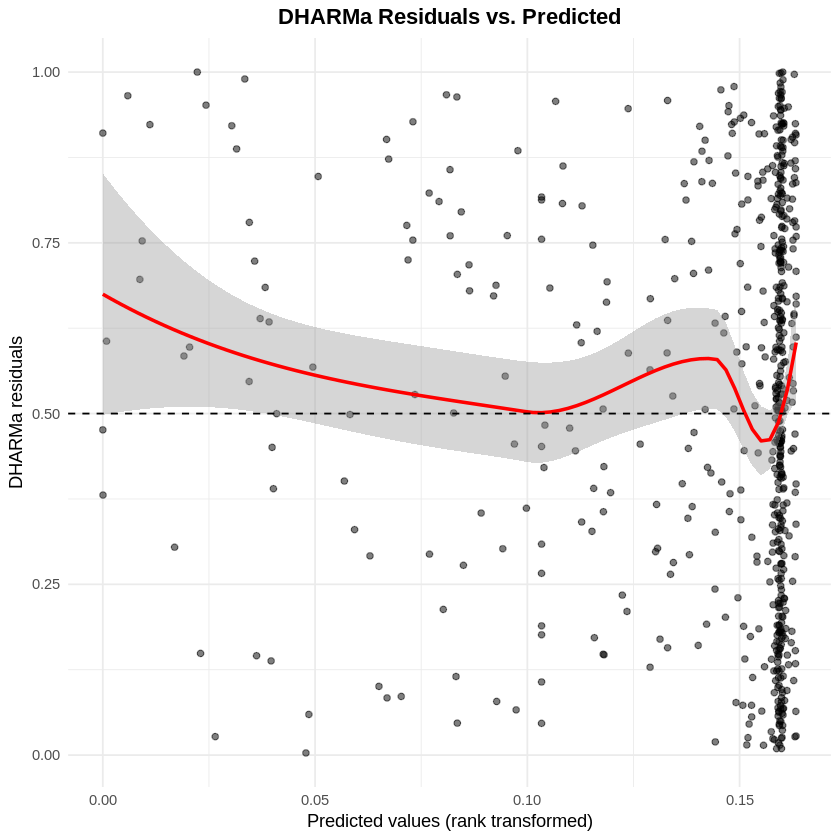

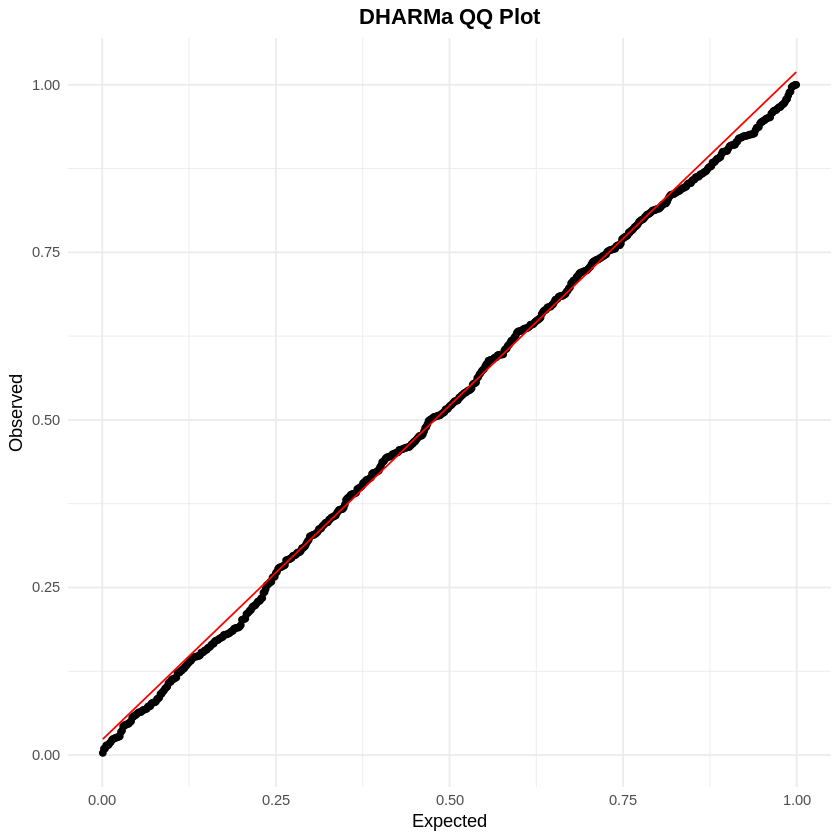

`geom_smooth()` using formula = 'y ~ x'


NULL
NULL
NULL
LaTeX code for model summary:

\begin{table}[h!]
\centering
\small
\begin{tabular}{|l r r r r|}
\hline
Conditional part & & & & \\
\hline
 & Estimate & Std.\ Error & z value & p \\ \hline
(Intercept) & -1.577 & 0.324 & -4.861 &   \\
SR_phon_phono_Norm & 0.276 & 0.246 & 1.122 &   \\
\hline
Zero-inflated part & & & & \\
\hline
(Intercept) & -1.136 & 0.762 & -1.490 &   \\
SR_phon_phono_Norm & 2.199 & 0.730 & 3.012 &   \\
\hline
\end{tabular}
\caption{Model capturing the relationship between number of disfluencies and normalised speech rate (with random effect for Speaker, Var = 0.227)} \label{model1}
\end{table}
\noindent


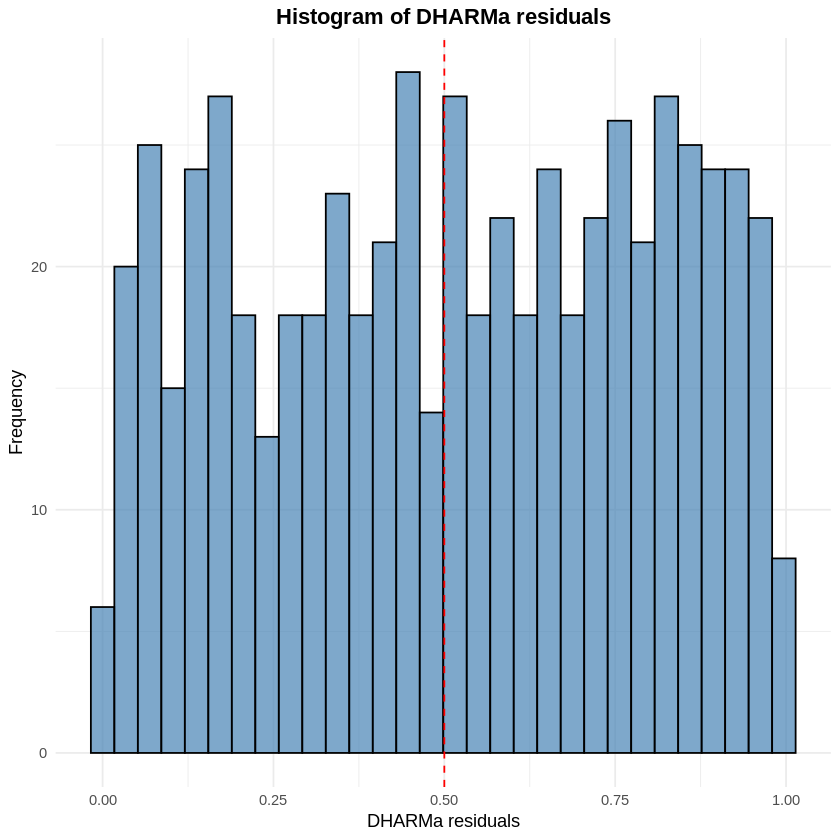

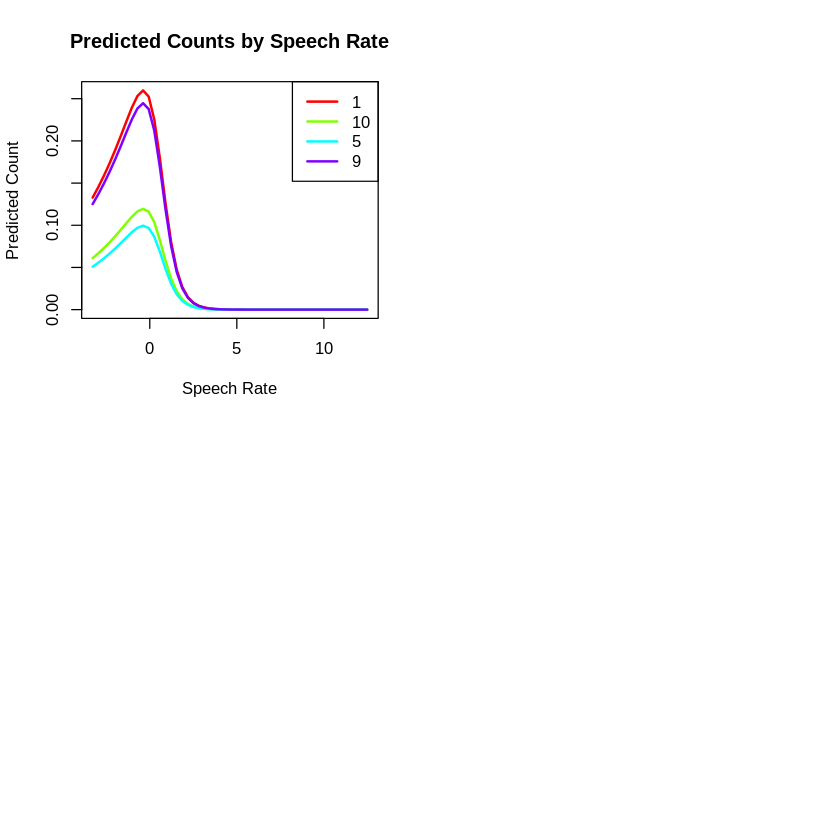

In [ ]:
########################################################################
#################N_BLD#############################################
########################################################################

zi_model <- glmmTMB(n_bld ~ SR_phon_phono_Norm + (1 | Speaker),
                 family = poisson,
                   ziformula = ~ SR_phon_phono_Norm,
                  data = data)
summary(zi_model)


######### Esecuzione della diagnostica#############
sim_residuals <- run_dharma_diagnostics(zi_model, "DHARMa diagnostics for Zero-inflated Poisson model")
residual_plots <- plot_dharma_residuals_ggplot(sim_residuals)


print(residual_plots$p1)
print(residual_plots$p2)
print(residual_plots$p3)


ggsave("dharma_residuals_vs_predicted.png", residual_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("dharma_qq_plot.png", residual_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("dharma_histogram.png", residual_plots$p3, width = 8, height = 6, dpi = 300)


####################Esecuzione dei plots##################

prediction_plots <- plot_zi_model_predictions(zi_model, data)

# Visualizzazione dei grafici
print(prediction_plots$p1)
print(prediction_plots$p2)
print(prediction_plots$p3)

# Salvataggio dei grafici
ggsave("zi_model_probability_zero.png", prediction_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("zi_model_expected_count.png", prediction_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("zi_model_vs_observed.png", prediction_plots$p3, width = 10, height = 6, dpi = 300)

###########Formattazione tabella in Latex##############

latex_output <- model_summary_latex(zi_model,
                                   "Model capturing the relationship between number of disfluencies and normalised speech rate",
                                   "model1")


cat("LaTeX code for model summary:\n\n")
cat(latex_output)

write(latex_output, "model_summary_latex.txt")

 Family: poisson  ( log )
Formula:          N_s ~ SR_phon_phono_Norm + (1 | Speaker)
Zero inflation:       ~SR_phon_phono_Norm
Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
   1800.3    1822.4    -895.1    1790.3       609 

Random effects:

Conditional model:
 Groups  Name        Variance Std.Dev.
 Speaker (Intercept) 0.0936   0.3059  
Number of obs: 614, groups:  Speaker, 4

Conditional model:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.43388    0.16430   2.641  0.00827 ** 
SR_phon_phono_Norm  0.35112    0.07973   4.404 1.06e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -0.529462   0.134497  -3.937 8.26e-05 ***
SR_phon_phono_Norm  0.003248   0.109127   0.030    0.976    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



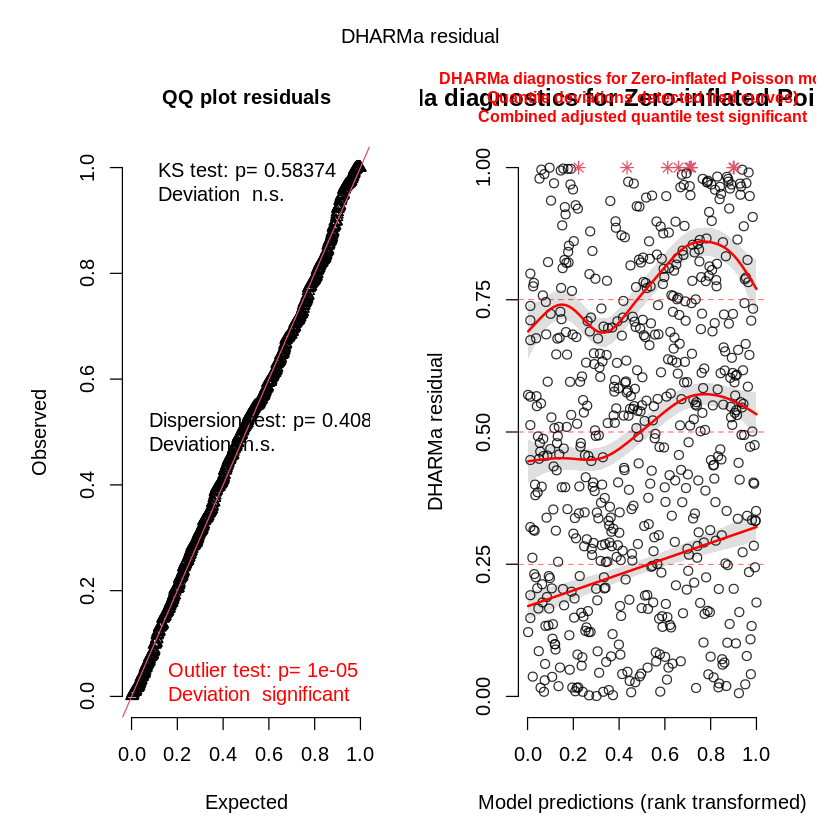

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details

`geom_smooth()` using formula = 'y ~ x'


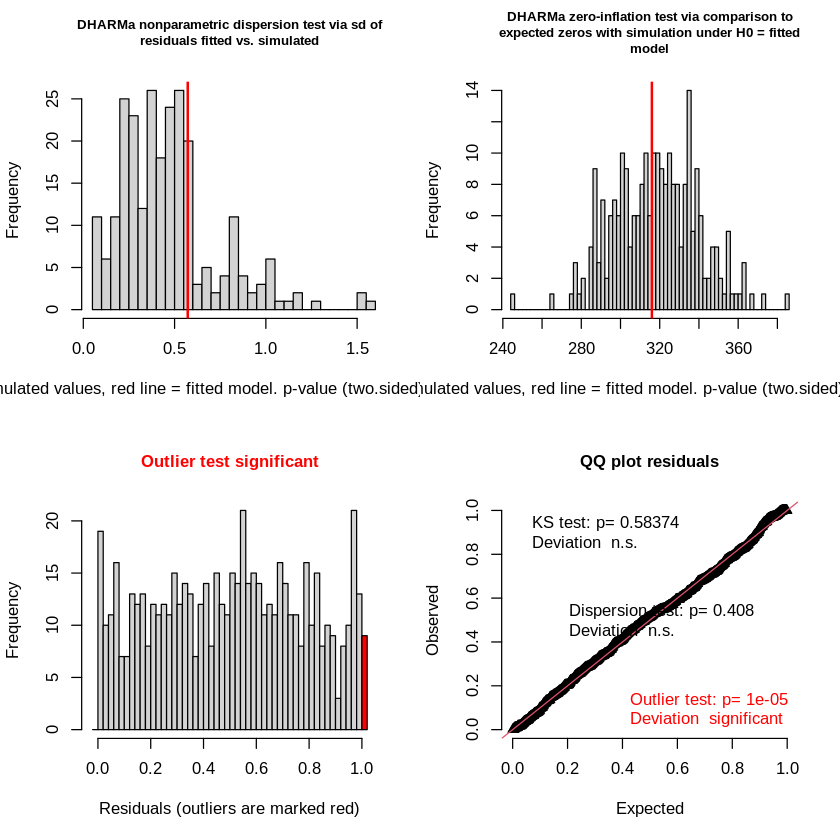

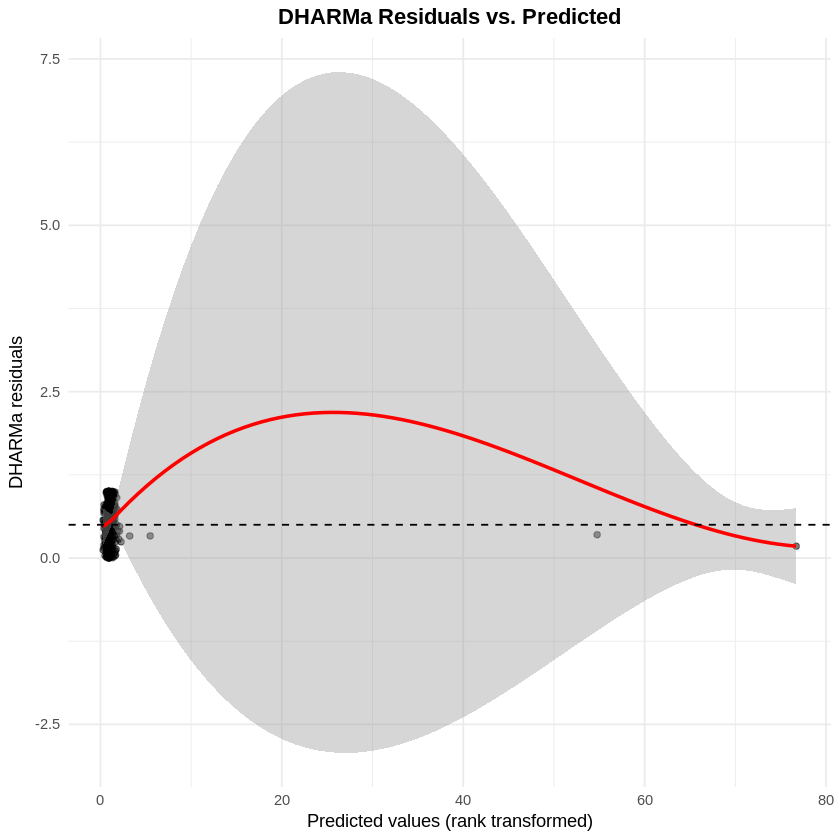

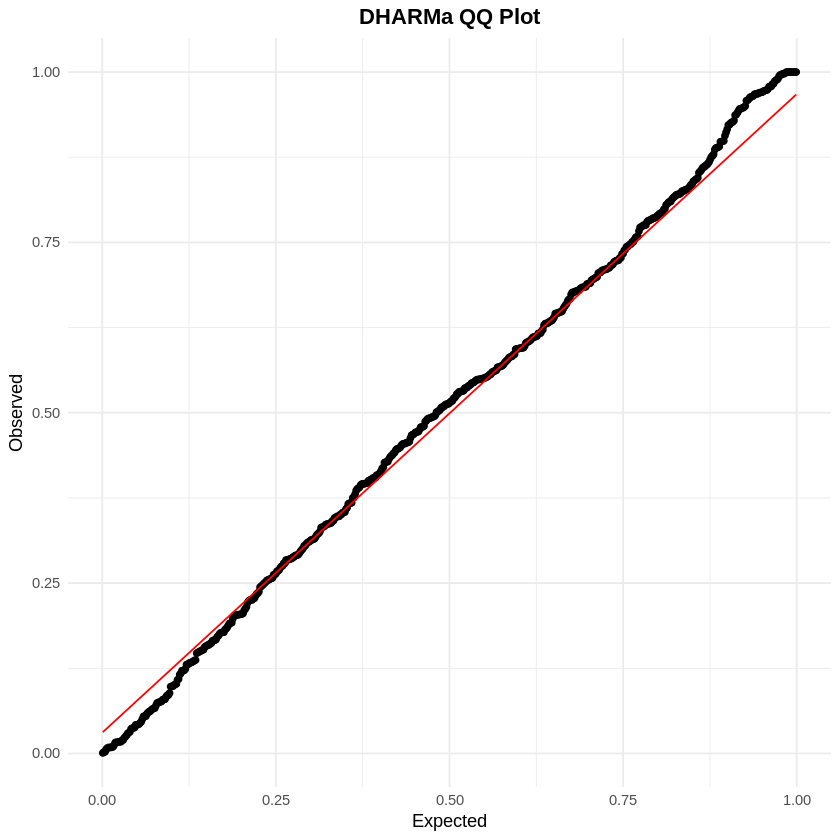

`geom_smooth()` using formula = 'y ~ x'


NULL
NULL
NULL
LaTeX code for model summary:

\begin{table}[h!]
\centering
\small
\begin{tabular}{|l r r r r|}
\hline
Conditional part & & & & \\
\hline
 & Estimate & Std.\ Error & z value & p \\ \hline
(Intercept) & 0.434 & 0.164 & 2.641 &   \\
SR_phon_phono_Norm & 0.351 & 0.080 & 4.404 &   \\
\hline
Zero-inflated part & & & & \\
\hline
(Intercept) & -0.529 & 0.134 & -3.937 &   \\
SR_phon_phono_Norm & 0.003 & 0.109 & 0.030 &   \\
\hline
\end{tabular}
\caption{Model capturing the relationship between number of disfluencies and normalised speech rate (with random effect for Speaker, Var = 0.094)} \label{model1}
\end{table}
\noindent


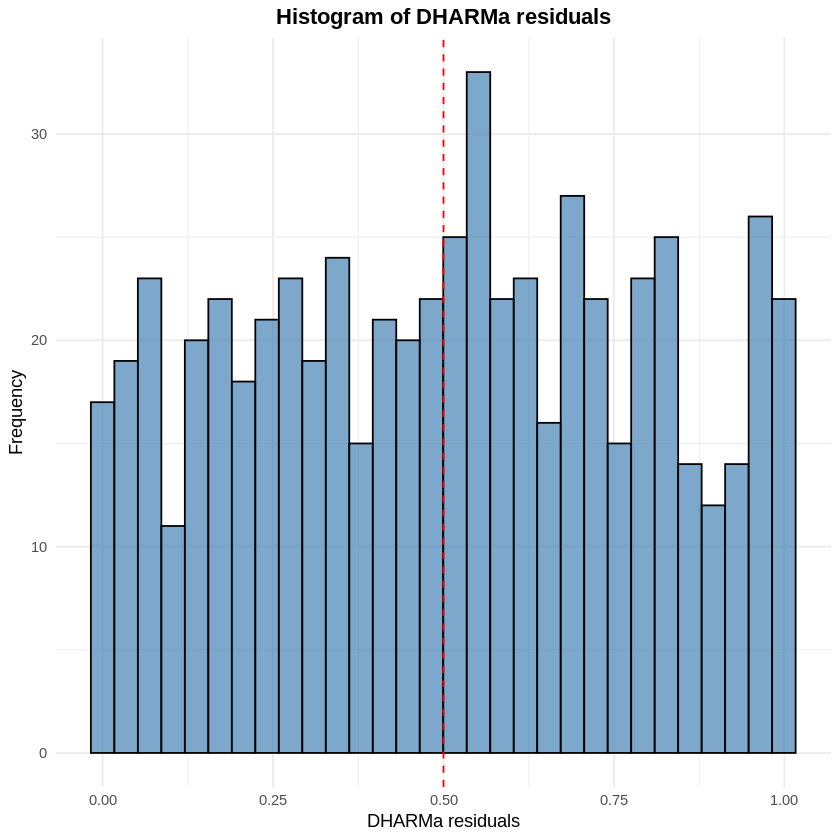

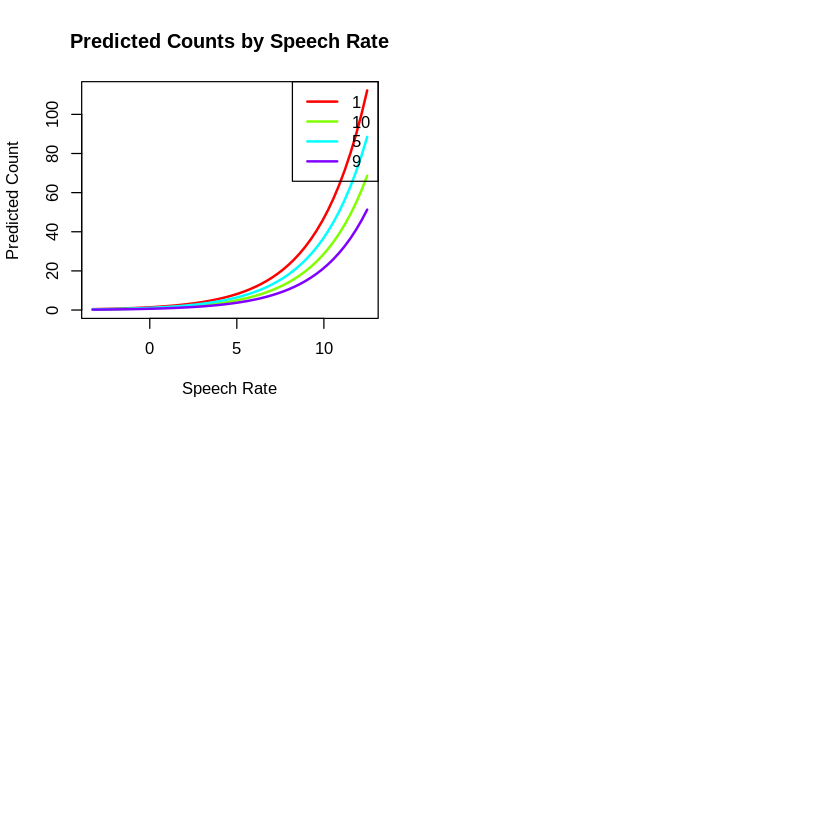

In [ ]:
########################################################################
#################N_s ~ SR_phon_phono_Norm#############################################
########################################################################

zi_model <- glmmTMB(N_s ~ SR_phon_phono_Norm + (1 | Speaker),
                 family = poisson,
                   ziformula = ~ SR_phon_phono_Norm,
                  data = data)
summary(zi_model)


######### Esecuzione della diagnostica#############
sim_residuals <- run_dharma_diagnostics(zi_model, "DHARMa diagnostics for Zero-inflated Poisson model")
residual_plots <- plot_dharma_residuals_ggplot(sim_residuals)


print(residual_plots$p1)
print(residual_plots$p2)
print(residual_plots$p3)


ggsave("dharma_residuals_vs_predicted.png", residual_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("dharma_qq_plot.png", residual_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("dharma_histogram.png", residual_plots$p3, width = 8, height = 6, dpi = 300)


####################Esecuzione dei plots##################

prediction_plots <- plot_zi_model_predictions(zi_model, data)

# Visualizzazione dei grafici
print(prediction_plots$p1)
print(prediction_plots$p2)
print(prediction_plots$p3)

# Salvataggio dei grafici
ggsave("zi_model_probability_zero.png", prediction_plots$p1, width = 8, height = 6, dpi = 300)
ggsave("zi_model_expected_count.png", prediction_plots$p2, width = 8, height = 6, dpi = 300)
ggsave("zi_model_vs_observed.png", prediction_plots$p3, width = 10, height = 6, dpi = 300)

###########Formattazione tabella in Latex##############

latex_output <- model_summary_latex(zi_model,
                                   "Model capturing the relationship between number of disfluencies and normalised speech rate",
                                   "model1")


cat("LaTeX code for model summary:\n\n")
cat(latex_output)

write(latex_output, "model_summary_latex.txt")

Warning message:
“La colonna speaker 'Speaker' non era un factor. È stata convertita.”


[1] "Formula utilizzata per il modello GAMM:"
[[1]]
DSTR_count ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

[[2]]
~s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

[1] "Formula utilizzata per il modello GAMM:"
[[1]]
DSTR_count ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

[[2]]
~s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

[1] "Inizio fitting del modello GAMM..."
[1] "Fitting completato."
Punto di inflection preciso a SR_phon_phono_Norm = 0.6649715 

Punto di cambiamento nella scala normalizzata: SR_phon_phono_Norm = 0.6649715 

Valori corrispondenti nella scala originale per ogni parlante:
 Speaker Original_Point  Mean    SD Median   Min    Max
       1          7.527 6.313 1.826  6.334 2.736 10.318
       5          5.552 4.645 1.364  4.615 1.787 10.184
       9          5.862 4.987 1.316  5.033 2.081  9.608
      10          5.757 4.975 1.176  4.973 2.180  7.815


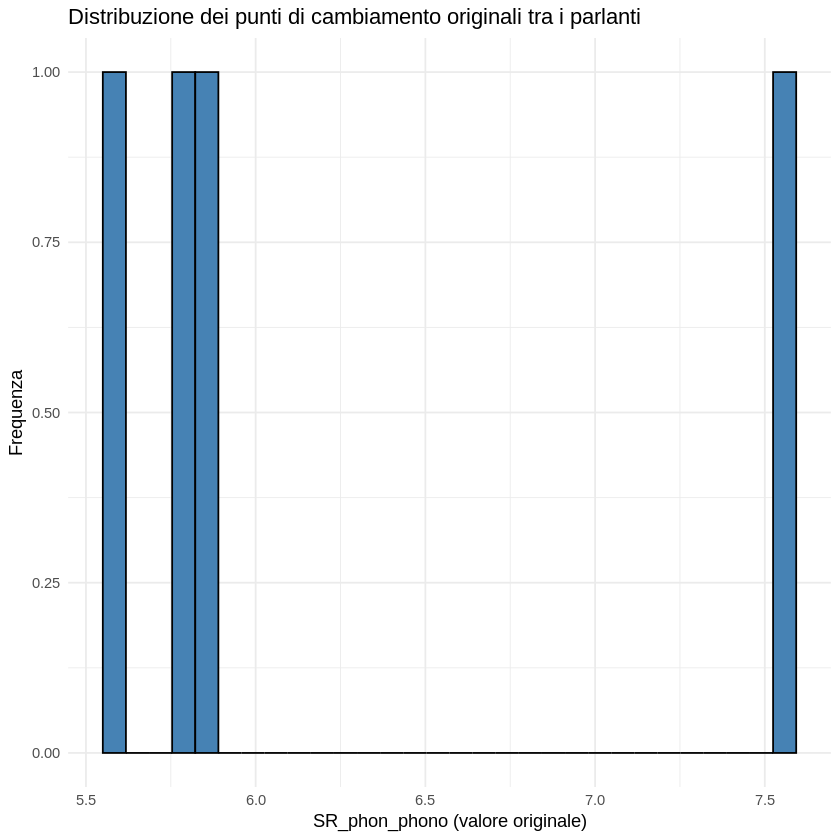


Statistiche descrittive dei punti di cambiamento originali:
Media: 6.174404 
Mediana: 5.809538 
Deviazione standard: 0.9106409 
Minimo: 5.551906 
Massimo: 7.526637 


`geom_smooth()` using formula = 'y ~ x'


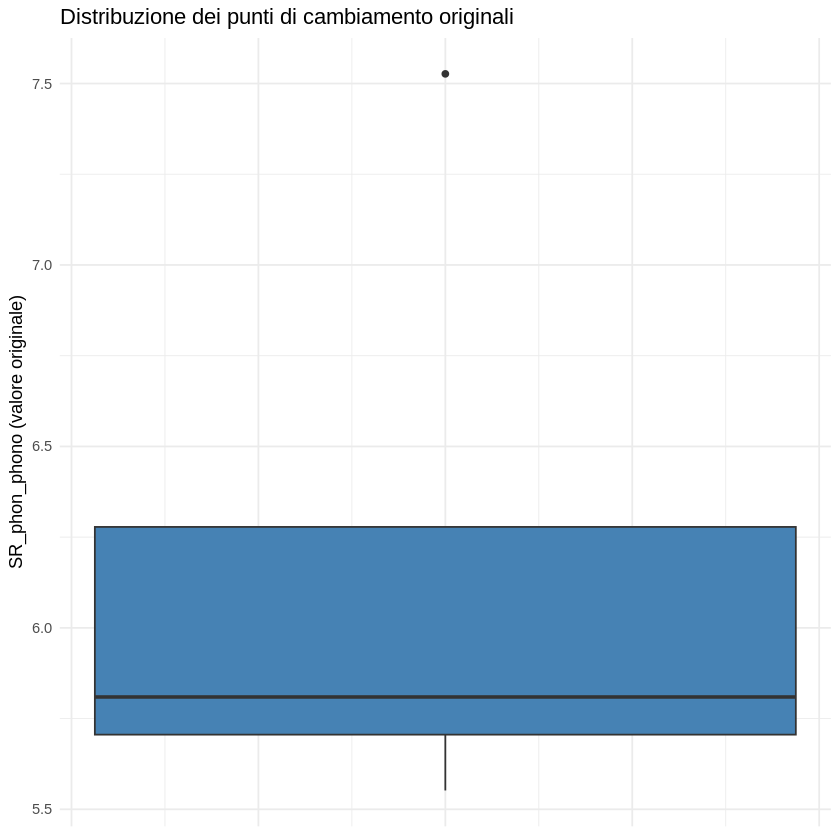


Correlazione tra media di SR_phon_phono e punto di cambiamento: 0.9957828 

Family: Zero inflated Poisson(-0.494,1.447) 
Link function: identity 

Formula:
DSTR_count ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.50767    0.08192   6.197 5.75e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df Chi.sq  p-value    
s(SR_phon_phono_Norm) 4.024  4.999  44.66  < 2e-16 ***
s(Speaker)            2.566  3.000  22.30 6.52e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Deviance explained = 9.41%
-REML = 953.17  Scale est. = 1         n = 591
[1] "Avvio diagnostica del modello..."


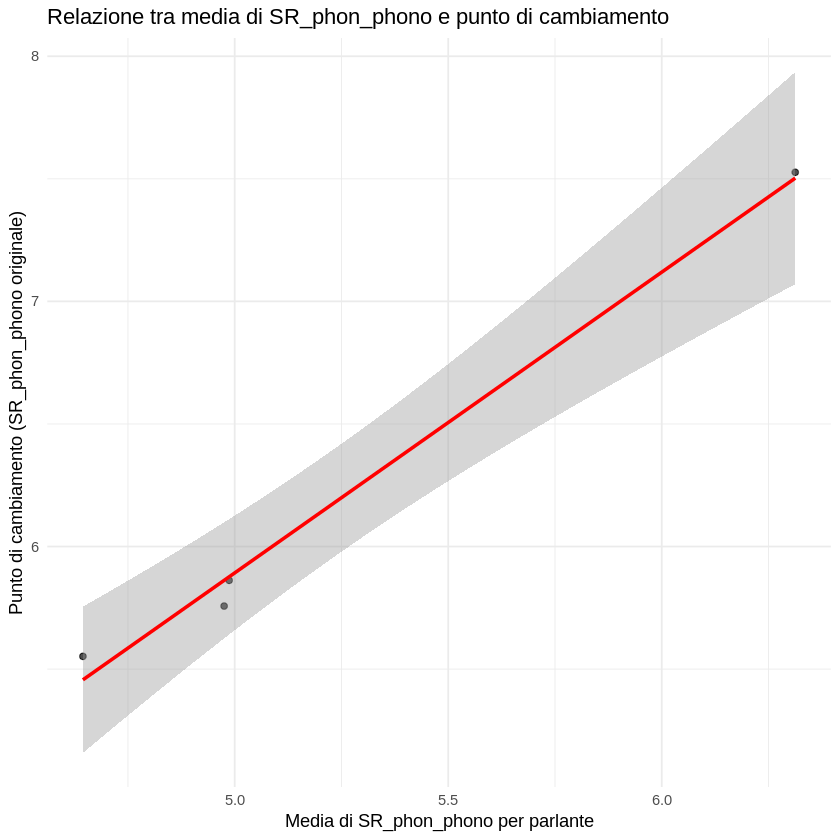


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-1.529795e-06,0.0003852528]
(score 953.1667 & scale 1).
Hessian positive definite, eigenvalue range [0.5408232,252.7987].
Model rank =  14 / 14 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                        k'  edf k-index p-value
s(SR_phon_phono_Norm) 9.00 4.02       1    0.66
s(Speaker)            4.00 2.57      NA      NA


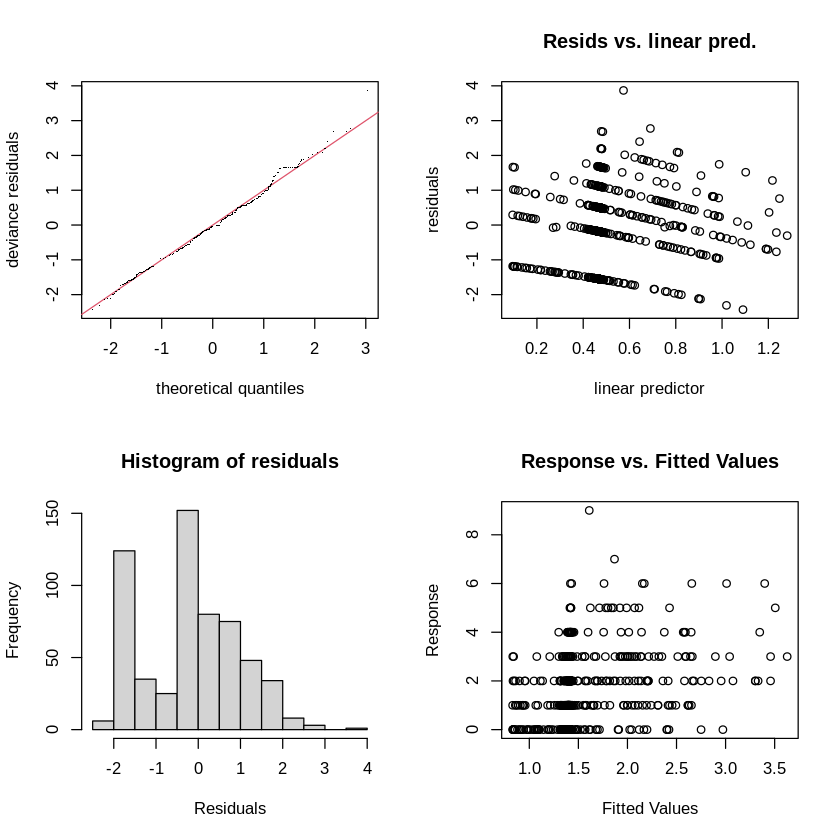

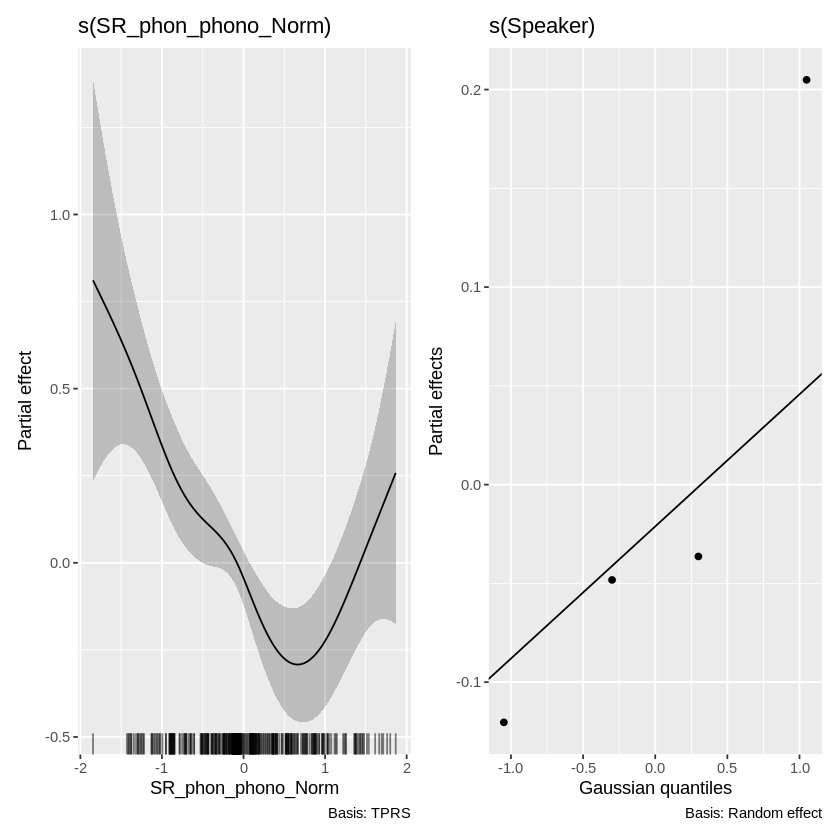

ERROR: Error in xtable(summary(zip_gamm)$p.table, caption = "Coefficienti parametrici"): could not find function "xtable"


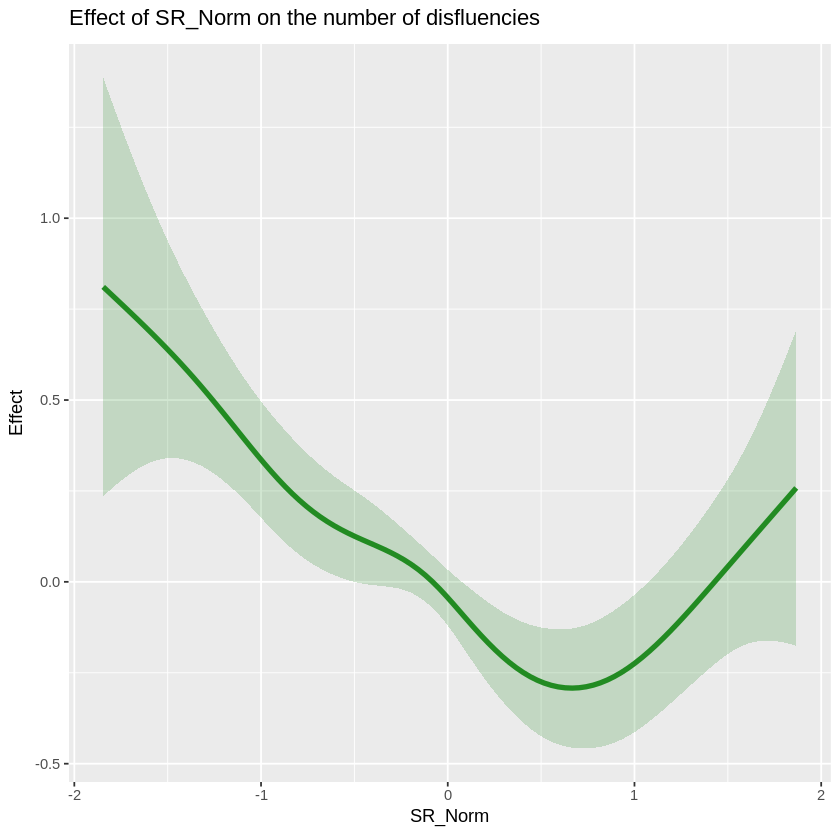

In [ ]:
# --- 1. Installazione e Caricamento Pacchetti ---
# Assicurati che i pacchetti necessari siano installati
#install.packages("mgcv")      # Per GAM e GAMM
#install.packages("ggplot2")   # Per grafici avanzati
#install.packages("dplyr")     # Per manipolazione dati
#install.packages("gratia")    # Per visualizzazione e diagnostica GAM migliorate
#install.packages("DHARMa")    # Per diagnostica residui avanzata (molto utile per GLMM/GAMM)
#install.packages("gratia")
library(mgcv)
library(ggplot2)
library(dplyr)
library(gratia)
library(DHARMa)

data <- read.csv("/content/df_disfl.csv")

# --- !!! PASSO PRELIMINARE: CARICA QUI I TUOI DATI !!! ---
#-----------------------------------------------------------------------

#
# your_dataframe <- read.csv("il_tuo_percorso/il_tuo_file.csv")
# # OPPURE
# your_dataframe <- readRDS("il_tuo_percorso/il_tuo_file.rds")
# # OPPURE se è già caricato nel tuo ambiente, assicurati che il nome
# # corrisponda a quello usato più avanti (qui chiamato 'your_dataframe').
#
# ASSICURATI CHE IL DATAFRAME SIA CARICATO PRIMA DI ESEGUIRE IL RESTO!
#-----------------------------------------------------------------------

# --- !!! PASSO FONDAMENTALE: SPECIFICA I NOMI DELLE COLONNE !!! ---
#-----------------------------------------------------------------------
# Sostituisci le stringhe qui sotto con i NOMI ESATTI delle colonne
# presenti nel tuo dataframe 'your_dataframe'.

nome_del_tuo_dataframe <- "data" # <-- SOSTITUISCI CON IL NOME DEL TUO DATAFRAME CARICATO

colonna_conteggio <- "DSTR_count"
colonna_predittore <- "SR_phon_phono_Norm"            # Questo è il predittore richiesto
colonna_speaker <- "Speaker"   # Es: "participante", "speaker_id"

#-----------------------------------------------------------------------
# DA QUI IN POI, IL CODICE USA I NOMI DEFINITI SOPRA.

# --- Preparazione Dati (Controllo e Conversione) ---

# Controlla se il dataframe esiste
if (!exists(nome_del_tuo_dataframe)) {
  stop(paste("Il dataframe specificato ('", nome_del_tuo_dataframe, "') non è stato trovato nel tuo ambiente R. Assicurati di averlo caricato correttamente.", sep=""))
}

# Rendi più facile riferirsi al dataframe (opzionale, ma comodo)
df <- get(nome_del_tuo_dataframe)

# Verifica che le colonne specificate esistano nel dataframe
colonne_necessarie <- c(colonna_conteggio, colonna_predittore, colonna_speaker)
colonne_mancanti <- colonne_necessarie[!colonne_necessarie %in% names(df)]
if (length(colonne_mancanti) > 0) {
  stop(paste("Le seguenti colonne specificate non esistono nel dataframe '", nome_del_tuo_dataframe, "': ",
             paste(colonne_mancanti, collapse = ", "),
             ". Controlla i nomi inseriti.", sep = ""))
}

# Assicurati che la variabile speaker sia un fattore (fondamentale per mgcv)
if (!is.factor(df[[colonna_speaker]])) {
  warning(paste("La colonna speaker '", colonna_speaker, "' non era un factor. È stata convertita.", sep = ""))
  df[[colonna_speaker]] <- as.factor(df[[colonna_speaker]])
}

# Controlli opzionali sul tipo di dati (generano warning se non corrispondono)
if (!is.numeric(df[[colonna_conteggio]])) {
    warning(paste("La colonna conteggio '", colonna_conteggio, "' non è numerica.", sep=""))
} else if (!all(floor(df[[colonna_conteggio]]) == df[[colonna_conteggio]], na.rm = TRUE) || !all(df[[colonna_conteggio]] >= 0, na.rm = TRUE)) {
    warning(paste("La colonna conteggio '", colonna_conteggio, "' contiene valori non interi o negativi. Verifica che sia appropriata per un modello Poisson.", sep=""))
}
if (!is.numeric(df[[colonna_predittore]])) {
    warning(paste("La colonna predittore '", colonna_predittore, "' non è numerica.", sep=""))
}




# --- 3. Fit del Modello GAMM Zero-Inflated Poisson ---
# Usiamo gam() con family = ziP(). Richiede una lista di due formule:
# 1. Formula per la componente Poisson (media lambda)
# 2. Formula per la componente Zero-Inflation (probabilità 1-pi)

# Costruiamo la formula dinamicamente usando i nomi delle colonne forniti
formula_list <- list(
  # Formula per log(lambda): conteggio ~ s(predittore) + s(speaker, random)
  reformulate(termlabels = c(paste0("s(", colonna_predittore, ")"),
                            paste0("s(", colonna_speaker, ", bs = 're')")),
              response = colonna_conteggio),

  # Formula per logit(1 - pi): ~ s(predittore) + s(speaker, random)
  # (lato sinistro omesso, usa implicitamente la stessa risposta)
  reformulate(termlabels = c(paste0("s(", colonna_predittore, ")"),
                            paste0("s(", colonna_speaker, ", bs = 're')")))
)

# Stampa la formula che verrà utilizzata (utile per debug)
print("Formula utilizzata per il modello GAMM:")
print(formula_list)

# --- 3. Fit del Modello GAMM Zero-Inflated Poisson ---
# ... (codice precedente per definire formula_list) ...

# Stampa la formula che verrà utilizzata (utile per debug)
print("Formula utilizzata per il modello GAMM:")
print(formula_list)


df <- df %>% filter(SR_phon_phono_Norm < 2 & SR_phon_phono_Norm > -2)
df <- df %>% filter(SR_phon_phono > 0)

# Fitta il modello
print("Inizio fitting del modello GAMM...")
zip_gamm <- gam(
  # CORREZIONE: Assegna esplicitamente la lista all'argomento 'formula'
  formula = DSTR_count ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re"),
  data = df,                  # Usa il tuo dataframe
  family = ziP(),             # Famiglia Zero-Inflated Poisson (con link di default log e logit)
  method = "REML"             # Metodo di stima
)
print("Fitting completato.")


###trovare il punto di cambiamento##

find_precise_inflection <- function(model, variable, data) {
  x_range <- range(data[[variable]], na.rm = TRUE)
  x_seq <- seq(x_range[1], x_range[2], length.out = 2000)

  speaker_ref <- data$Speaker[1]
  newdata <- data.frame(
    SR_phon_phono_Norm = x_seq,
    Speaker = rep(speaker_ref, length(x_seq))
  )

  preds <- predict(model, newdata = newdata, type = "response")

  # Calcola la derivata numerica
  derivative <- diff(preds) / diff(x_seq)

  # Trova dove la derivata cambia segno da negativa a positiva
  sign_changes <- which(diff(sign(derivative)) > 0)

  if (length(sign_changes) > 0) {
    # Prendi il primo punto di cambiamento
    inflection_idx <- sign_changes[1] + 1  # +1 perché diff riduce la lunghezza
    inflection_x <- x_seq[inflection_idx]
    inflection_y <- preds[inflection_idx]

    cat("Punto di inflection preciso a SR_phon_phono_Norm =", inflection_x, "\n")
    return(inflection_x)
  } else {
    cat("Nessun punto di inflection trovato con questo metodo.\n")
    return(NULL)
  }
}
precise_point <- find_precise_inflection(zip_gamm, "SR_phon_phono_Norm", df)


calculate_normalization_params <- function(data) {
  speakers <- unique(data$Speaker)

  # Crea un dataframe per memorizzare i parametri
  params <- data.frame(
    Speaker = speakers,
    Mean = numeric(length(speakers)),
    SD = numeric(length(speakers)),
    Original_Point = numeric(length(speakers)),
    stringsAsFactors = FALSE
  )

  # Calcola media e deviazione standard per ogni parlante
  for (i in 1:length(speakers)) {
    speaker_data <- subset(data, Speaker == speakers[i])

    # Verifica se ci sono dati sufficienti
    if (nrow(speaker_data) > 1) {
      params$Mean[i] <- mean(speaker_data$SR_phon_phono, na.rm = TRUE)
      params$SD[i] <- sd(speaker_data$SR_phon_phono, na.rm = TRUE)
      params$Median[i] <- median(speaker_data$SR_phon_phono, na.rm = TRUE)
      params$Min[i] <- min(speaker_data$SR_phon_phono, na.rm = TRUE)
      params$Max[i] <- max(speaker_data$SR_phon_phono, na.rm = TRUE)


      # Calcola il punto originale
      params$Original_Point[i] <- precise_point * params$SD[i] + params$Mean[i]
    } else {
      params$Mean[i] <- NA
      params$SD[i] <- NA
      params$Original_Point[i] <- NA
      params$Median[i] <- NA
      params$Min[i] <- NA
      params$Max[i] <- NA
    }
  }

  return(params)
}

# Calcola i parametri e i punti originali per tutti i parlanti
speaker_params <- calculate_normalization_params(df)

# Mostra i risultati
cat("\nPunto di cambiamento nella scala normalizzata: SR_phon_phono_Norm =", precise_point, "\n\n")
cat("Valori corrispondenti nella scala originale per ogni parlante:\n")

# Formatta e visualizza i risultati in una tabella
if (nrow(speaker_params) <= 50) {
  # Se ci sono meno di 50 parlanti, mostra tutti
  print(speaker_params[, c("Speaker", "Original_Point", "Mean", "SD", "Median", "Min", "Max")],
        row.names = FALSE, digits = 4)
} else {
  # Altrimenti mostra solo i primi 20
  cat("Mostrando i primi 20 parlanti (su", nrow(speaker_params), "totali):\n")
  print(speaker_params[1:20, c("Speaker", "Original_Point", "Mean", "SD")],
        row.names = FALSE, digits = 4)
}

# Creazione di un istogramma o boxplot dei punti originali
library(ggplot2)

# Istogramma
hist_plot <- ggplot(speaker_params, aes(x = Original_Point)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "black") +
  labs(title = "Distribuzione dei punti di cambiamento originali tra i parlanti",
       x = "SR_phon_phono (valore originale)",
       y = "Frequenza") +
  theme_minimal()

print(hist_plot)

# Boxplot
box_plot <- ggplot(speaker_params, aes(y = Original_Point)) +
  geom_boxplot(fill = "steelblue") +
  labs(title = "Distribuzione dei punti di cambiamento originali",
       y = "SR_phon_phono (valore originale)") +
  theme_minimal() +
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

print(box_plot)

# Statistiche descrittive dei punti originali
cat("\nStatistiche descrittive dei punti di cambiamento originali:\n")
cat("Media:", mean(speaker_params$Original_Point, na.rm = TRUE), "\n")
cat("Mediana:", median(speaker_params$Original_Point, na.rm = TRUE), "\n")
cat("Deviazione standard:", sd(speaker_params$Original_Point, na.rm = TRUE), "\n")
cat("Minimo:", min(speaker_params$Original_Point, na.rm = TRUE), "\n")
cat("Massimo:", max(speaker_params$Original_Point, na.rm = TRUE), "\n")

# Salva i risultati in un file CSV (opzionale)
# write.csv(speaker_params, "punti_cambiamento_parlanti.csv", row.names = FALSE)

# Scatterplot che mostra la relazione tra la media di SR_phon_phono e il punto di cambiamento
scatter_plot <- ggplot(speaker_params, aes(x = Mean, y = Original_Point)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", color = "red") +
  labs(title = "Relazione tra media di SR_phon_phono e punto di cambiamento",
       x = "Media di SR_phon_phono per parlante",
       y = "Punto di cambiamento (SR_phon_phono originale)") +
  theme_minimal()

print(scatter_plot)

# Calcola la correlazione
correlation <- cor(speaker_params$Mean, speaker_params$Original_Point,
                   use = "complete.obs")
cat("\nCorrelazione tra media di SR_phon_phono e punto di cambiamento:", correlation, "\n")

# --- 4. Sommario del Modello ---
# ... (il resto del codice rimane invariato) ...

# --- 4. Sommario del Modello ---
# Fornisce info su significatività, EDF, varianze random, deviance spiegata, etc.
print(summary(zip_gamm))

# --- 5. Diagnostica del Modello ---

print("Avvio diagnostica del modello...")

# 5.1 Diagnostica base di mgcv

par(mfrow = c(2, 2)) # Prepara layout grafico 2x2
tryCatch({
    gam.check(zip_gamm)
}, error = function(e) {
    warning("gam.check() ha prodotto un errore. Potrebbe essere dovuto a problemi del modello o alla famiglia ZI. Controlla i warning precedenti e la diagnostica DHARMa.")
    print(e)
})
par(mfrow = c(1, 1)) # Resetta layout grafico


# --- 6. Visualizzazione del Modello ---

draw(zip_gamm, ci.col = "teal")

sm <- smooth_estimates(zip_gamm, smooth = "s(SR_phon_phono_Norm)")

sm |>
  add_confint() |>
  ggplot(aes(y = .estimate, x = SR_phon_phono_Norm)) +
  geom_ribbon(aes(ymin = .lower_ci, ymax = .upper_ci),
    alpha = 0.2, fill = "forestgreen"
  ) +
  geom_line(colour = "forestgreen", linewidth = 1.5) +
  labs(
    y = "Effect",
    title = expression("Effect of SR_Norm on the number of disfluencies"),
    x = expression("SR_Norm")
  )


parametric_table <- xtable(summary(zip_gamm)$p.table,
                        caption = "Coefficienti parametrici")

# Poi crea una tabella per i termini di smoothing
smooth_table <- xtable(summary(zip_gamm)$s.table,
                     caption = "Termini di smoothing")

# Stampa le tabelle
print(parametric_table, comment = FALSE)
print(smooth_table, comment = FALSE)

[1] "Inizio fitting del modello GAMM..."
[1] "Fitting completato."

Family: Zero inflated Poisson(-0.073,1.338) 
Link function: identity 

Formula:
n_FLD ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   0.1937     0.0959   2.019   0.0434 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df Chi.sq  p-value    
s(SR_phon_phono_Norm) 3.812  4.745  54.08  < 2e-16 ***
s(Speaker)            2.586  3.000  22.95 4.78e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Deviance explained = 10.8%
-REML = 850.41  Scale est. = 1         n = 591
[1] "Avvio diagnostica del modello..."

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-2.608605e-05,3.877594e-05]
(score 850.408 & scale 1).
Hessian positive definite, eigenvalue range [0.6657199,146.4042].


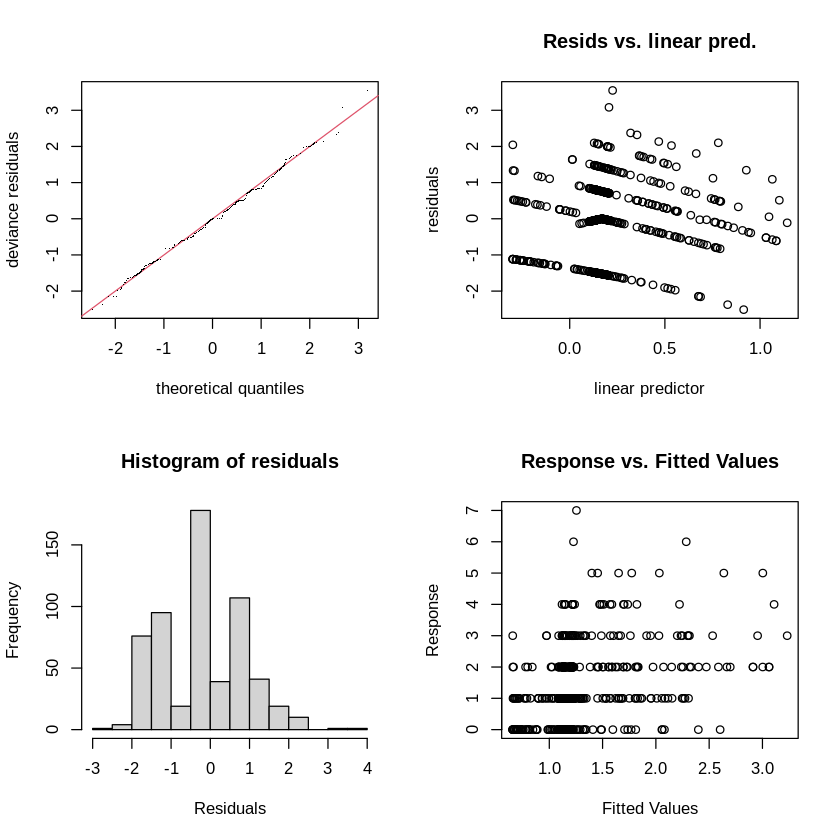

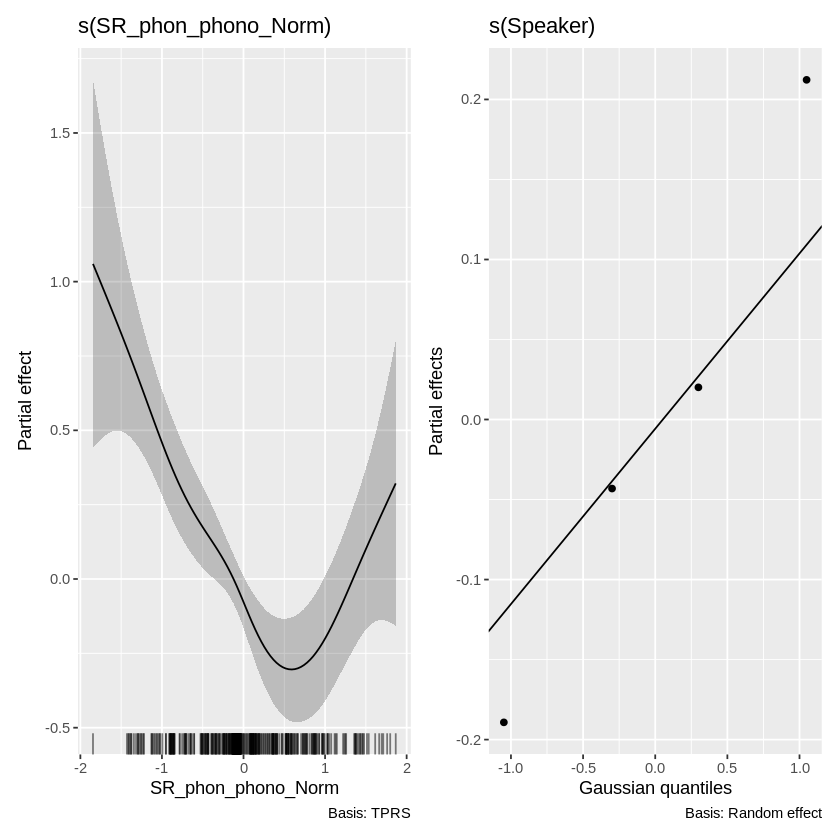

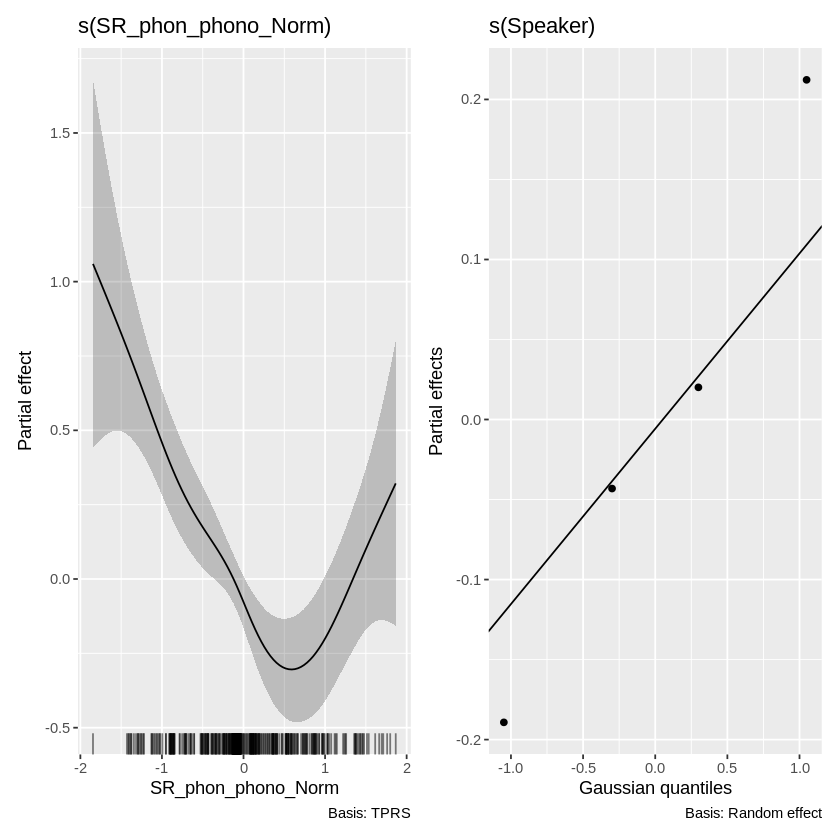

ERROR: Error in xtable(summary(zip_gamm)$p.table, caption = "Coefficienti parametrici"): could not find function "xtable"


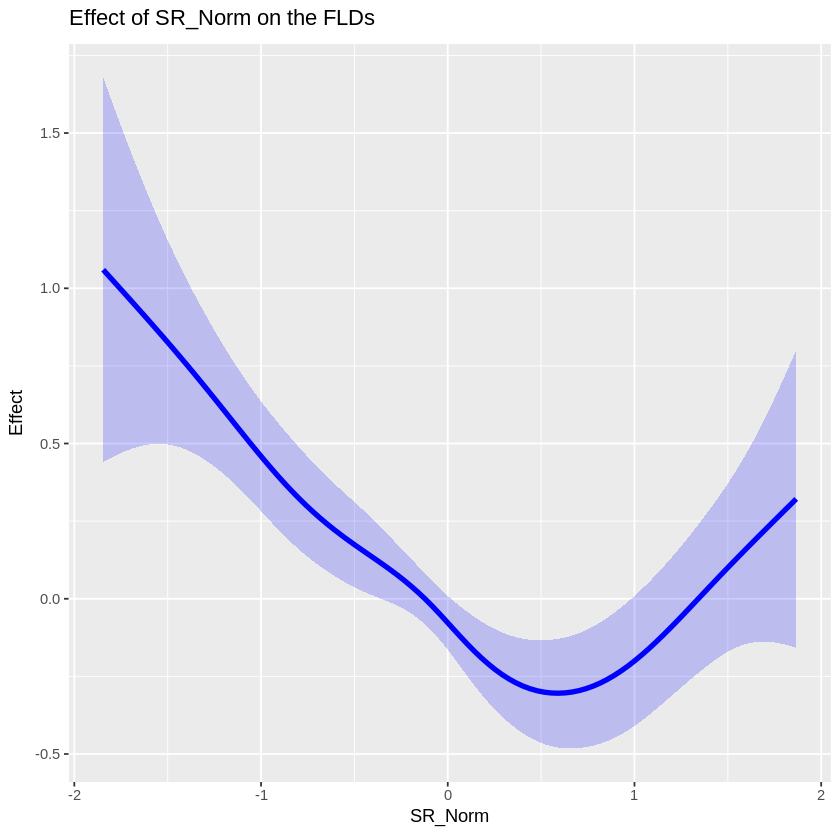

In [ ]:
######################
######FLD#############
#####################





print("Inizio fitting del modello GAMM...")
zip_gamm <- gam(
  # CORREZIONE: Assegna esplicitamente la lista all'argomento 'formula'
  formula = n_FLD ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re"),
  data = df,                  # Usa il tuo dataframe
  family = ziP(),             # Famiglia Zero-Inflated Poisson (con link di default log e logit)
  method = "REML"             # Metodo di stima
)
print("Fitting completato.")

# --- 4. Sommario del Modello ---
# ... (il resto del codice rimane invariato) ...

# --- 4. Sommario del Modello ---
# Fornisce info su significatività, EDF, varianze random, deviance spiegata, etc.
print(summary(zip_gamm))

# --- 5. Diagnostica del Modello ---

print("Avvio diagnostica del modello...")

# 5.1 Diagnostica base di mgcv

par(mfrow = c(2, 2)) # Prepara layout grafico 2x2
tryCatch({
    gam.check(zip_gamm)
}, error = function(e) {
    warning("gam.check() ha prodotto un errore. Potrebbe essere dovuto a problemi del modello o alla famiglia ZI. Controlla i warning precedenti e la diagnostica DHARMa.")
    print(e)
})
par(mfrow = c(1, 1)) # Resetta layout grafico


# --- 6. Visualizzazione del Modello ---

draw(zip_gamm, ci.col = "Black")



# --- 6. Visualizzazione del Modello ---

draw(zip_gamm, ci.col = "teal")

sm <- smooth_estimates(zip_gamm, smooth = "s(SR_phon_phono_Norm)")

sm |>
  add_confint() |>
  ggplot(aes(y = .estimate, x = SR_phon_phono_Norm)) +
  geom_ribbon(aes(ymin = .lower_ci, ymax = .upper_ci),
    alpha = 0.2, fill = "blue"
  ) +
  geom_line(colour = "blue", linewidth = 1.5) +
  labs(
    y = "Effect",
    title = expression("Effect of SR_Norm on the FLDs"),
    x = expression("SR_Norm")
  )


parametric_table <- xtable(summary(zip_gamm)$p.table,
                        caption = "Coefficienti parametrici")

# Poi crea una tabella per i termini di smoothing
smooth_table <- xtable(summary(zip_gamm)$s.table,
                     caption = "Termini di smoothing")

# Stampa le tabelle
print(parametric_table, comment = FALSE)
print(smooth_table, comment = FALSE)


[1] "Inizio fitting del modello GAMM..."
[1] "Fitting completato."

Family: Zero inflated Poisson(-1.24,0.063) 
Link function: identity 

Formula:
n_bld ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)   -10.79       4.79  -2.253   0.0242 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df Chi.sq  p-value    
s(SR_phon_phono_Norm) 3.703  4.598  12.80   0.0224 *  
s(Speaker)            2.680  3.000  30.43 3.22e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Deviance explained =   36%
-REML =  272.5  Scale est. = 1         n = 593
[1] "Avvio diagnostica del modello..."

Method: REML   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-1.609268e-07,2.588743e-07]
(score 272.5018 & scale 1).
Hessian positive definite, eigenvalue range [0.1625533,61.69502].


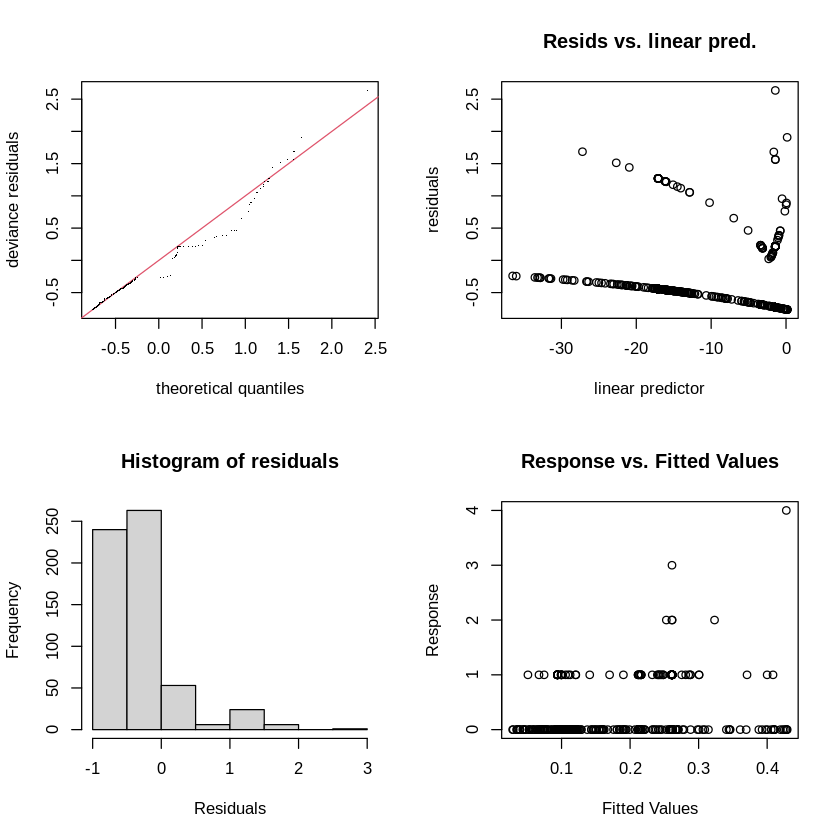

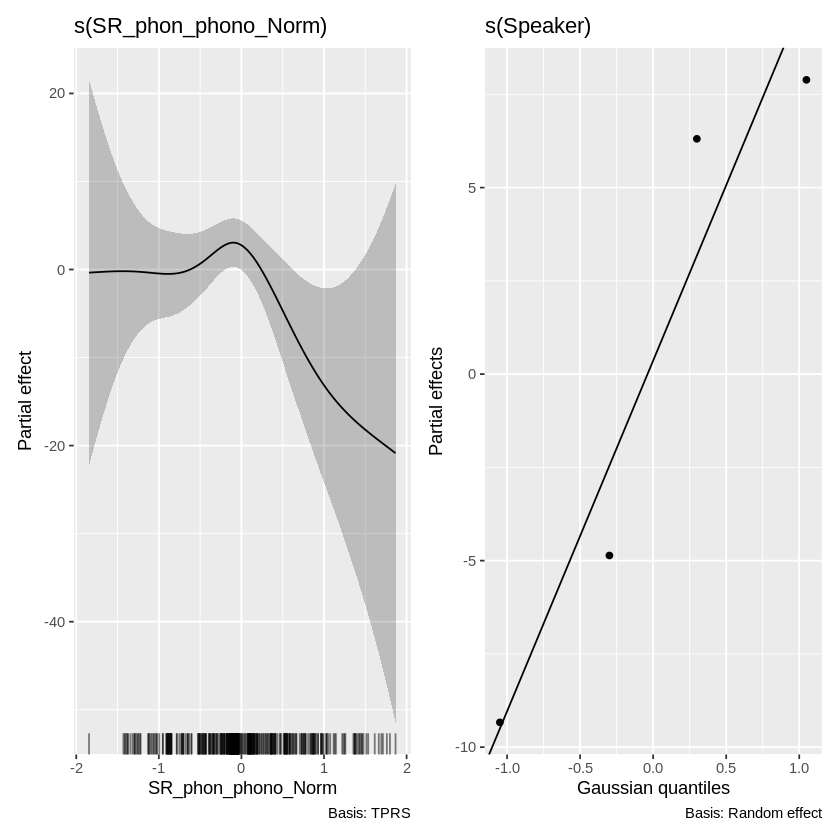

ERROR: Error in xtable(summary(zip_gamm)$p.table, caption = "Coefficienti parametrici"): could not find function "xtable"


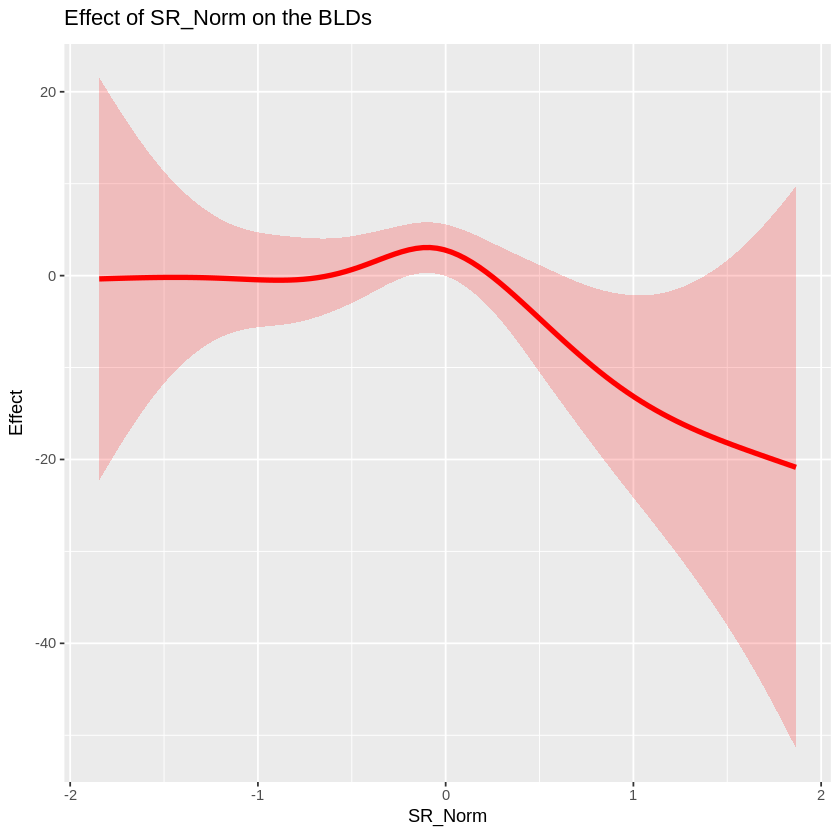

In [ ]:
######################
######BLD#############
#####################





print("Inizio fitting del modello GAMM...")
zip_gamm <- gam(
  # CORREZIONE: Assegna esplicitamente la lista all'argomento 'formula'
  formula = n_bld ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re"),
  data = df,                  # Usa il tuo dataframe
  family = ziP(),             # Famiglia Zero-Inflated Poisson (con link di default log e logit)
  method = "REML"             # Metodo di stima
)
print("Fitting completato.")

# --- 4. Sommario del Modello ---
# ... (il resto del codice rimane invariato) ...

# --- 4. Sommario del Modello ---
# Fornisce info su significatività, EDF, varianze random, deviance spiegata, etc.
print(summary(zip_gamm))

# --- 5. Diagnostica del Modello ---

print("Avvio diagnostica del modello...")

# 5.1 Diagnostica base di mgcv

par(mfrow = c(2, 2)) # Prepara layout grafico 2x2
tryCatch({
    gam.check(zip_gamm)
}, error = function(e) {
    warning("gam.check() ha prodotto un errore. Potrebbe essere dovuto a problemi del modello o alla famiglia ZI. Controlla i warning precedenti e la diagnostica DHARMa.")
    print(e)
})
par(mfrow = c(1, 1)) # Resetta layout grafico


# --- 6. Visualizzazione del Modello ---

draw(zip_gamm, ci.col = "Black")

sm <- smooth_estimates(zip_gamm, smooth = "s(SR_phon_phono_Norm)")

sm |>
  add_confint() |>
  ggplot(aes(y = .estimate, x = SR_phon_phono_Norm)) +
  geom_ribbon(aes(ymin = .lower_ci, ymax = .upper_ci),
    alpha = 0.2, fill = "red"
  ) +
  geom_line(colour = "red", linewidth = 1.5) +
  labs(
    y = "Effect",
    title = expression("Effect of SR_Norm on the BLDs"),
    x = expression("SR_Norm")
  )


parametric_table <- xtable(summary(zip_gamm)$p.table,
                        caption = "Coefficienti parametrici")

# Poi crea una tabella per i termini di smoothing
smooth_table <- xtable(summary(zip_gamm)$s.table,
                     caption = "Termini di smoothing")

# Stampa le tabelle
print(parametric_table, comment = FALSE)
print(smooth_table, comment = FALSE)


[1] "Inizio fitting del modello GAMM..."
[1] "Fitting completato."

Family: Zero inflated Poisson(-0.932,1.07) 
Link function: identity 

Formula:
N_s ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   0.4800     0.1623   2.958   0.0031 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                        edf Ref.df Chi.sq  p-value    
s(SR_phon_phono_Norm) 2.370  2.979  28.07 3.26e-06 ***
s(Speaker)            2.794  3.000  44.70  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Deviance explained = 11.9%
-REML = 876.43  Scale est. = 1         n = 593
[1] "Avvio diagnostica del modello..."

Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-6.248027e-08,9.693385e-08]
(score 876.4309 & scale 1).
Hessian positive definite, eigenvalue range [0.4304546,236.8194].


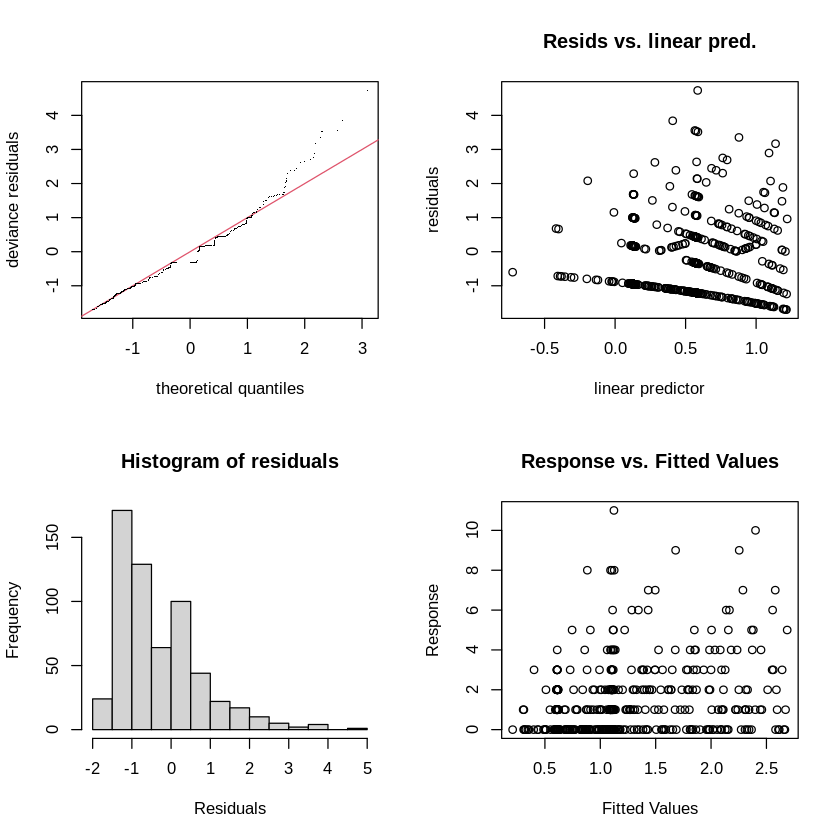

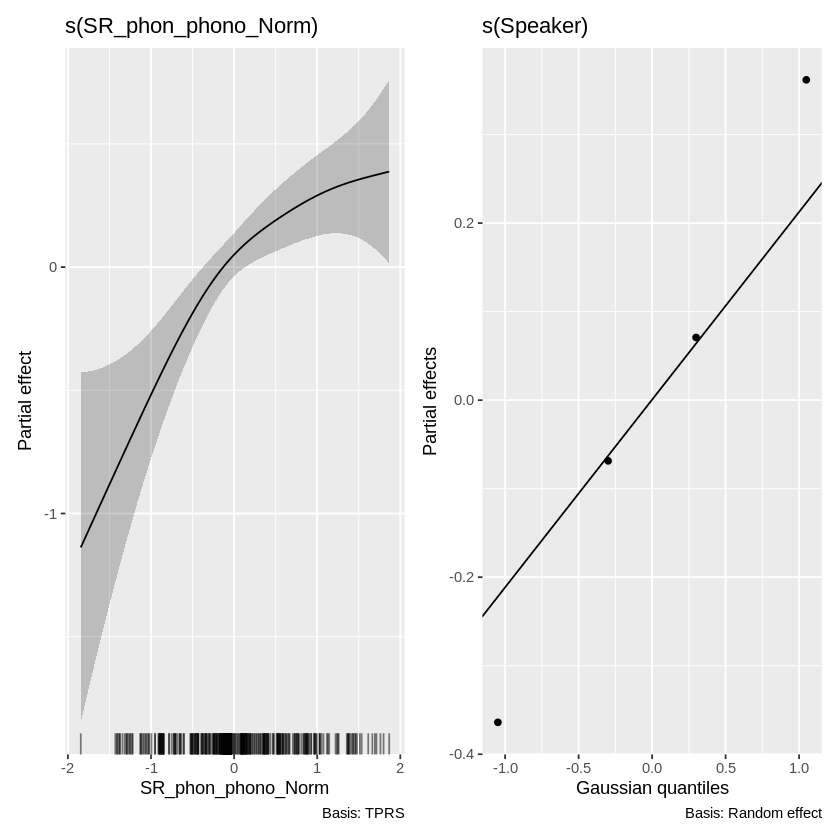

\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & Estimate & Std. Error & z value & Pr($>$$|$z$|$) \\ 
  \hline
(Intercept) & 0.48 & 0.16 & 2.96 & 0.00 \\ 
   \hline
\end{tabular}
\caption{Coefficienti parametrici} 
\end{table}
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & edf & Ref.df & Chi.sq & p-value \\ 
  \hline
s(SR\_phon\_phono\_Norm) & 2.37 & 2.98 & 28.07 & 0.00 \\ 
  s(Speaker) & 2.79 & 3.00 & 44.70 & 0.00 \\ 
   \hline
\end{tabular}
\caption{Termini di smoothing} 
\end{table}


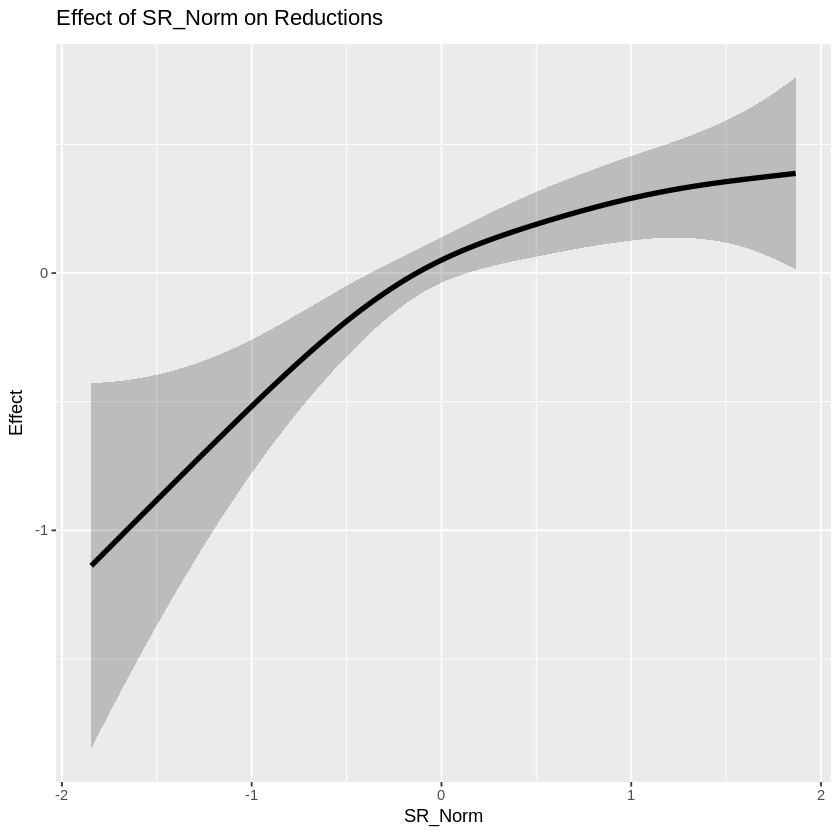

In [ ]:
######################
######N_s and speech rate#############
#####################





print("Inizio fitting del modello GAMM...")
zip_gamm <- gam(
  # CORREZIONE: Assegna esplicitamente la lista all'argomento 'formula'
  formula = N_s ~ s(SR_phon_phono_Norm) + s(Speaker, bs = "re"),
  data = df,                  # Usa il tuo dataframe
  family = ziP(),             # Famiglia Zero-Inflated Poisson (con link di default log e logit)
  method = "REML"             # Metodo di stima
)
print("Fitting completato.")

# --- 4. Sommario del Modello ---
# ... (il resto del codice rimane invariato) ...

# --- 4. Sommario del Modello ---
# Fornisce info su significatività, EDF, varianze random, deviance spiegata, etc.
print(summary(zip_gamm))

# --- 5. Diagnostica del Modello ---

print("Avvio diagnostica del modello...")

# 5.1 Diagnostica base di mgcv

par(mfrow = c(2, 2)) # Prepara layout grafico 2x2
tryCatch({
    gam.check(zip_gamm)
}, error = function(e) {
    warning("gam.check() ha prodotto un errore. Potrebbe essere dovuto a problemi del modello o alla famiglia ZI. Controlla i warning precedenti e la diagnostica DHARMa.")
    print(e)
})
par(mfrow = c(1, 1)) # Resetta layout grafico


# --- 6. Visualizzazione del Modello ---

draw(zip_gamm, ci.col = "Black")
sm <- smooth_estimates(zip_gamm, smooth = "s(SR_phon_phono_Norm)")

sm |>
  add_confint() |>
  ggplot(aes(y = .estimate, x = SR_phon_phono_Norm)) +
  geom_ribbon(aes(ymin = .lower_ci, ymax = .upper_ci),
    alpha = 0.2, fill = "black"
  ) +
  geom_line(colour = "black", linewidth = 1.5) +
  labs(
    y = "Effect",
    title = expression("Effect of SR_Norm on Reductions"),
    x = expression("SR_Norm")
  )


parametric_table <- xtable(summary(zip_gamm)$p.table,
                        caption = "Coefficienti parametrici")

# Poi crea una tabella per i termini di smoothing
smooth_table <- xtable(summary(zip_gamm)$s.table,
                     caption = "Termini di smoothing")

# Stampa le tabelle
print(parametric_table, comment = FALSE)
print(smooth_table, comment = FALSE)

[1] "Inizio fitting del modello GAMM..."
[1] "Fitting completato."

Family: Zero inflated Poisson(-0.777,0.771) 
Link function: identity 

Formula:
N_s ~ s(DSTR_count, k = 9) + s(Speaker, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   0.4852     0.1841   2.636   0.0084 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                edf Ref.df Chi.sq  p-value    
s(DSTR_count) 1.001  1.002  21.41 4.96e-06 ***
s(Speaker)    2.806  3.000  46.22  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Deviance explained = 10.7%
-REML = 879.17  Scale est. = 1         n = 593
[1] "Avvio diagnostica del modello..."

Method: REML   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-0.0004032993,0.0004246655]
(score 879.1712 & scale 1).
Hessian positive definite, eigenvalue range [0.0004030759,244.7557].
Model rank =  13 / 13

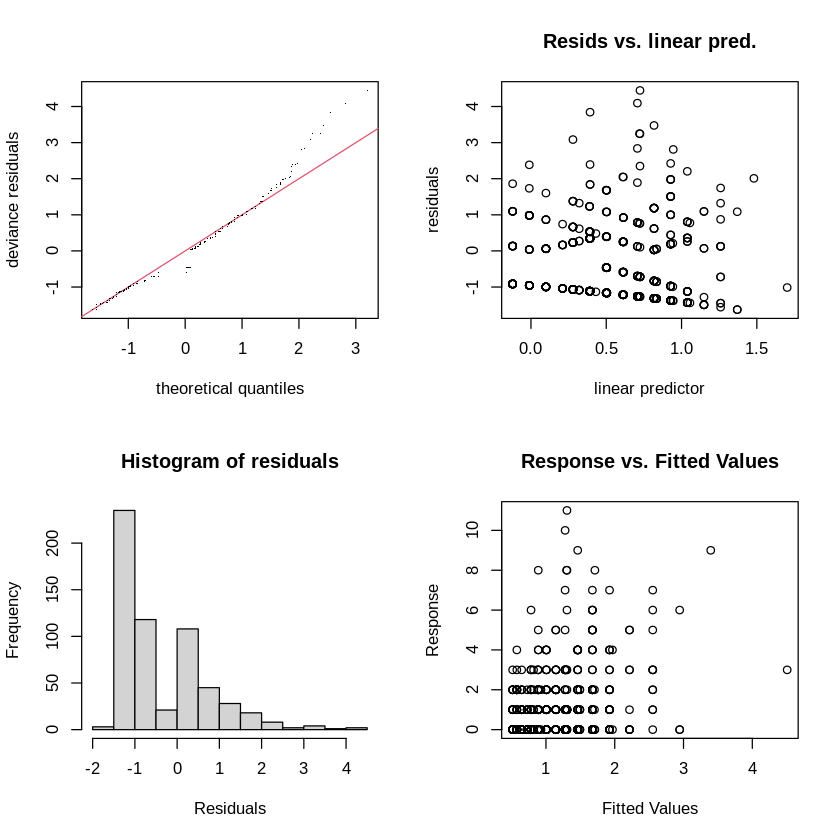

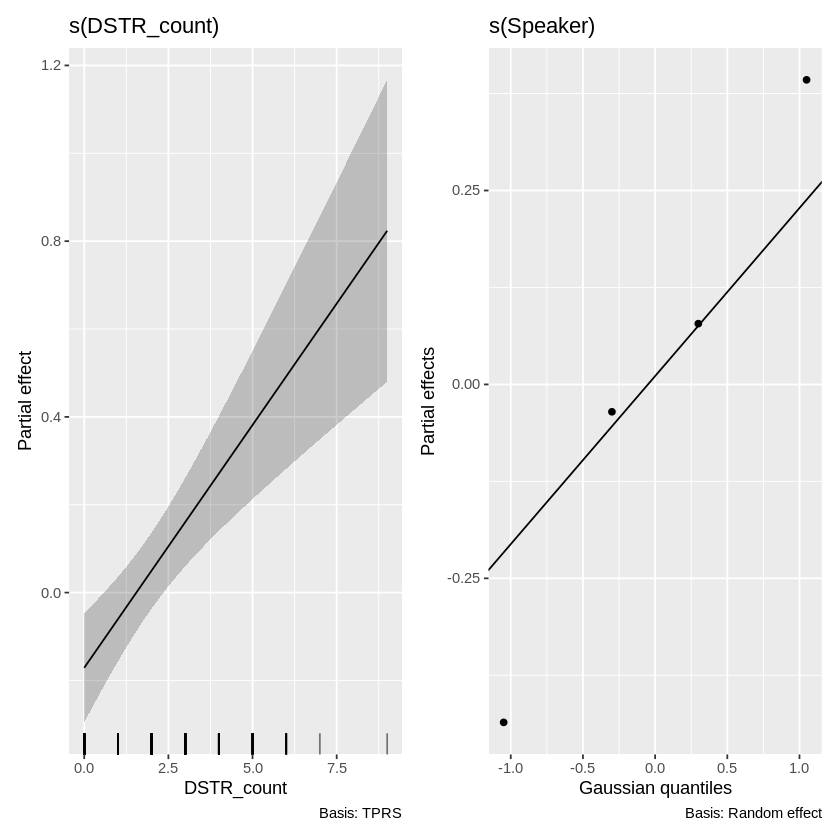

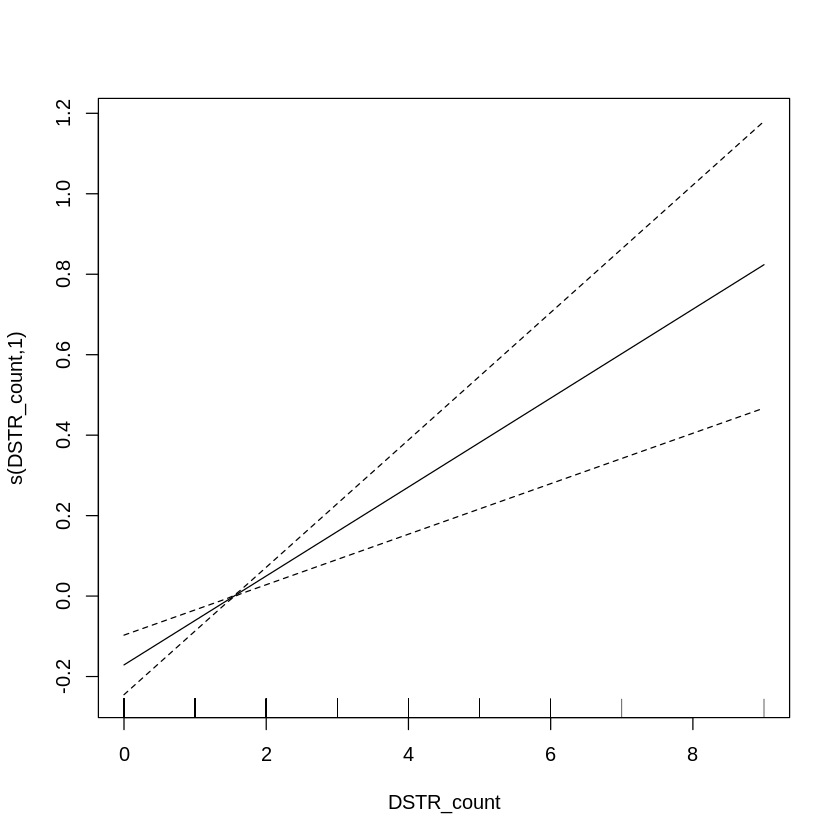

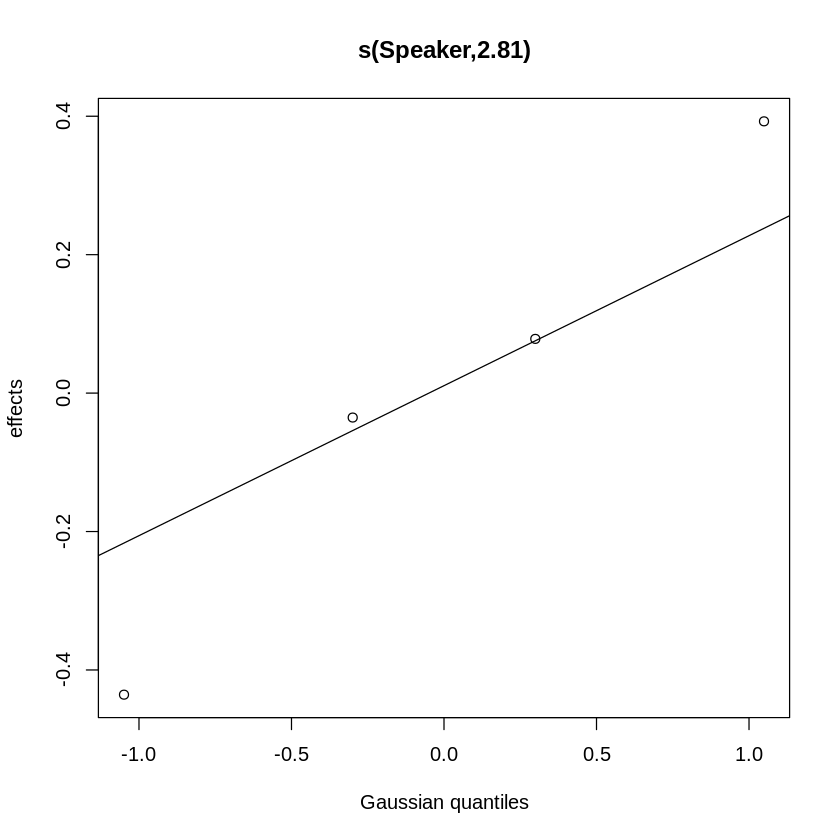

In [ ]:
######################
######N_S DSTR_count#############
#####################





print("Inizio fitting del modello GAMM...")
zip_gamm <- gam(
  # CORREZIONE: Assegna esplicitamente la lista all'argomento 'formula'
  formula = N_s ~ s(DSTR_count, k = 9) + s(Speaker, bs = "re"),
  data = df,                  # Usa il tuo dataframe
  family = ziP(),             # Famiglia Zero-Inflated Poisson (con link di default log e logit)
  method = "REML"             # Metodo di stima
)
print("Fitting completato.")

# --- 4. Sommario del Modello ---
# ... (il resto del codice rimane invariato) ...

# --- 4. Sommario del Modello ---
# Fornisce info su significatività, EDF, varianze random, deviance spiegata, etc.
print(summary(zip_gamm))

# --- 5. Diagnostica del Modello ---

print("Avvio diagnostica del modello...")

# 5.1 Diagnostica base di mgcv

par(mfrow = c(2, 2)) # Prepara layout grafico 2x2
tryCatch({
    gam.check(zip_gamm)
}, error = function(e) {
    warning("gam.check() ha prodotto un errore. Potrebbe essere dovuto a problemi del modello o alla famiglia ZI. Controlla i warning precedenti e la diagnostica DHARMa.")
    print(e)
})
par(mfrow = c(1, 1)) # Resetta layout grafico


# --- 6. Visualizzazione del Modello ---

draw(zip_gamm, ci.col = "Black")
plot(zip_gamm)



